# **Prova Substitutiva DTAT - Fase 02**
Aluna responsável: Flora Serafim de Carvalho | RM354000

# 1.Objetivos

Criar um modelo preditivo de séries temporais para prever diariamente os dados de fechamento da bolsa de valores do IBOVESPA, de modo que este modelo tenha uma assertividade de pelo menos 80%, auxiliando na tomada de decisões.<br><br>

A entrega deve conter demonstrações como:
*   Storytelling com a análise dos dados e contexto dos picos de alta e baixa
dos dados.
*   Análise de decomposição da série temporal.
*   Explicação do modelo utilizado e quais são as vantagens.
*   Demonstração dos resultados com métricas estatísticas e predição dos
próximos 15 dias.

# 2.Instalação e importação de funções e pacotes

In [1]:
!pip install yfinance --quiet --upgrade
!pip install sqlalchemy polars --quiet

import os
import yfinance as yf
import pandas as pd
import numpy as np
import sqlalchemy as db
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random
import tensorflow as tf


from datetime import datetime, timedelta
from google.colab import data_table
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import timedelta
from pandas.tseries.offsets import BDay

# 3.Aquisição da base de dados




Os dados do IBOVESPA são disponibilizados através [deste link](https://br.investing.com/indices/bovespa-historical-data).
Porém, para que tenhamos uma base de dados sempre atualizada e que seja capaz de prever datas futuras, independente de quando for consultada, a solução encontrada foi utilizar as informações direto da API do Yahoo Finance.<br><br>

Para garantir esta atualização, foram realizados os dois passos abaixo:

1.   Baixar os dados históricos do IBOVESPA através da API, usando o pacote "yfinance";
2.   Criar um banco de dados SQLite para gravar todos esses dados baixados na etapa 1.<br><br>

Assim, toda vez que o código for executado, serão pegos os dados históricos dos 10 anos anteriores à data de execução.




## 3.1 Baixar os dados históricos do IBOVESPA

In [2]:
# Define o ticker e intervalo de 10 anos
ticker = '^BVSP'
data_final = datetime.today()
data_inicial = data_final - timedelta(days=3652) #considerando 2 anos bissextos

df_ibov = yf.download(
    ticker,
    start=data_inicial.strftime('%Y-%m-%d'),
    end=data_final.strftime('%Y-%m-%d'),
    interval='1d'
)

# Ajuste dos nomes das colunas
df_ibov = df_ibov.reset_index()
df_ibov.columns = [
    (col[0] if isinstance(col, tuple) else col).lower().replace(' ', '_')
    for col in df_ibov.columns
]


/tmp/ipython-input-1899692621.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_ibov = yf.download(
[*********************100%***********************]  1 of 1 completed


##3.2 Criar um Banco de dados SQLite

In [3]:
# Criar e salvar a tabela
engine = db.create_engine('sqlite:///ibovespa.db')

df_ibov.to_sql('ibovespa', con=engine, index=False, if_exists='replace')


2479

# 4.Leitura e pré-processamento para análise de dados




In [4]:
# Consulta dos dados no banco
query = "SELECT * FROM ibovespa;"
with engine.connect() as conn:
    result = conn.execute(db.text(query))
    data = result.fetchall()
    colunas = result.keys()

# Criar o DataFrame
df_raw = pl.DataFrame(
    [list(row) for row in data],
    schema=list(colunas),
    orient="row"
)

# Converter a string datetime para apenas data
df_raw = df_raw.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d %H:%M:%S%.f")
)

# Gerar série temporal
df2 = df_raw.select(
    pl.col("date").alias("ds"),
    pl.col("close").alias("y")
)


df2.describe()

statistic,ds,y
str,str,f64
"""count""","""2479""",2479.0
"""null_count""","""0""",0.0
"""mean""","""2020-08-16 22:29:57.821000""",97095.664784
"""std""",null,26540.096391
"""min""","""2015-08-14""",37497.0
"""25%""","""2018-02-19""",75976.0
"""50%""","""2020-08-18""",103446.0
"""75%""","""2023-02-15""",118228.0
"""max""","""2025-08-12""",141478.0


O IBOVESPA terá dados vinculados apenas em dias úteis.  Para evitar valores nulos em feriados e fins de semana, o código abaixo será utilizado para que seja vinculado o valor correspondente ao dia útil anterior.

In [5]:
# Definindo o intervalo de datas
data_inicio = df2['ds'].min()
data_fim = df2['ds'].max()

# Criando uma lista de datas
lista_datas = [data_inicio + timedelta(days=d) for d in range((data_fim - data_inicio).days + 1)]

# Criando o DataFrame com a coluna de datas e uma coluna de valores nulos
df_dates = pl.DataFrame({
    "ds": lista_datas
})

df2 = df_dates.join(df2, on='ds', how='left').sort('ds').fill_null(strategy='forward')

# 5.Análise Exploratória dos dados

Considerando o pré-processamento realizado nas etapas anteriores deste notebook, é possível gerar um gráfico com o histórico de pontos IBOVESPA dos últimos 10 anos. Abaixo, segue código e visualização inicial.

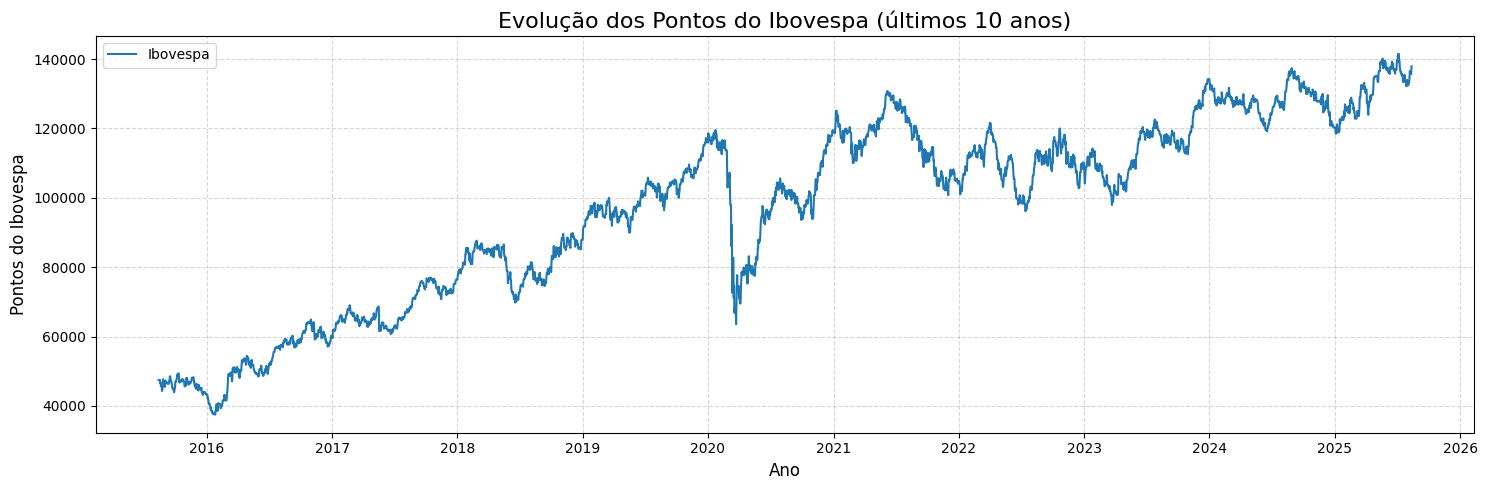

In [6]:
plt.figure(figsize=(15, 5))

sns.lineplot(data=df2, x='ds', y='y', label='Ibovespa')

# Personalizações
plt.title('Evolução dos Pontos do Ibovespa (últimos 10 anos)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Pontos do Ibovespa', fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, linestyle='--', alpha=0.5)

# Layout ajustado para evitar corte nos rótulos
plt.tight_layout()


plt.show()

## 5.1 Picos de altas e baixas do IBOVESPA

Para detectar os picos de altas e baixas do IBOVESPA, foram determinados os limites superiores e inferiores de cada um dos 10 anos. Todos os valores fora deste intervalo de limites, serão nossos *Outliers*.<br><br>

Para calcular os limites, foi adotado o seguinte cálculo:<br>
<img src="https://github.com/florascarvalho/Prova_Substitutiva_DTAT_Fase2/raw/main/imagens/equação_1.jpg" width="200"><br>

Na equação foi considerado "2x o desvio", pois em uma distribuição normal (Gaussiana), é esperado que 95% dos dados de uma amostra esteja neste intervalo.



In [7]:
# Converter o Dataframe para Pandas
df2 = df2.to_pandas()
df2 = df2.reset_index()

# Criar coluna com ano, extraindo a informação da data
df2['ano'] = pd.to_datetime(df2['ds']).dt.year

# Inicializar a coluna de outliers
df2['is_outlier'] = False

# Looping ano a ano para identificar os outliers
for ano in df2['ano'].unique():
    grupo = df2[df2['ano'] == ano]
    media = grupo['y'].mean()
    desvio = grupo['y'].std()
    limite_sup = media + 2 * desvio
    limite_inf = media - 2 * desvio
    cond = (grupo['y'] > limite_sup) | (grupo['y'] < limite_inf)
    df2.loc[grupo.index[cond], 'is_outlier'] = True

Preparação para a plotagem com os *Outliers*.

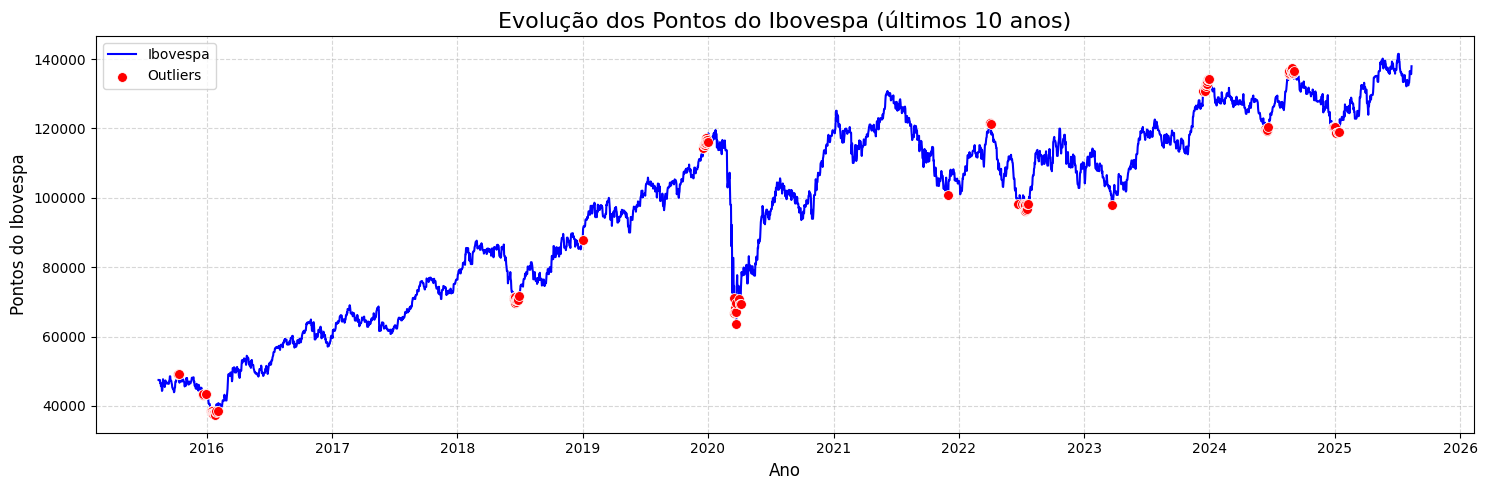

In [8]:
df = df2.copy()

# Separar outliers
outliers = df[df['is_outlier'] == True]

# Plotar gráfico
plt.figure(figsize=(15, 5))

# Linha do Ibovespa
sns.lineplot(data=df, x='ds', y='y', label='Ibovespa', color='blue')

# Pontos dos outliers
sns.scatterplot(data=outliers, x='ds', y='y', color='red', label='Outliers', s=50, marker='o', zorder=5)

# Personalizações
plt.title('Evolução dos Pontos do Ibovespa (últimos 10 anos)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Pontos do Ibovespa', fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.legend()


plt.show()

O próximo passo é identificar todas as datas que estão com os valores médios fora dos limites. Dessa forma, é possível buscar maores informações sobre as causas de alta ou queda da bolsa.

Será essencial para criação de um dicionário auxiliar, que será detalhado nas etapas seguintes.

In [9]:
# Filtrar os outliers marcados
outliers = df2[df2['is_outlier'] == True]

# Selecionar apenas as colunas de interesse
datas_outliers = outliers[['ds', 'y']]
datas_outliers['ds'] = pd.to_datetime(datas_outliers['ds']).dt.strftime('%d/%m/%Y')
pd.set_option('display.max_rows', None)

print(datas_outliers)


              ds         y
56    09/10/2015   49338.0
57    10/10/2015   49338.0
58    11/10/2015   49338.0
59    12/10/2015   49338.0
129   21/12/2015   43200.0
130   22/12/2015   43470.0
138   30/12/2015   43350.0
139   31/12/2015   43350.0
154   15/01/2016   38569.0
155   16/01/2016   38569.0
156   17/01/2016   38569.0
157   18/01/2016   37937.0
158   19/01/2016   38057.0
159   20/01/2016   37645.0
160   21/01/2016   37717.0
161   22/01/2016   38031.0
162   23/01/2016   38031.0
163   24/01/2016   38031.0
164   25/01/2016   38031.0
165   26/01/2016   37497.0
166   27/01/2016   38376.0
167   28/01/2016   38630.0
172   02/02/2016   38596.0
1035  14/06/2018   71421.0
1036  15/06/2018   70758.0
1037  16/06/2018   70758.0
1038  17/06/2018   70758.0
1039  18/06/2018   69815.0
1040  19/06/2018   71394.0
1042  21/06/2018   70075.0
1043  22/06/2018   70641.0
1044  23/06/2018   70641.0
1045  24/06/2018   70641.0
1046  25/06/2018   70953.0
1047  26/06/2018   71405.0
1048  27/06/2018   70609.0
1

/tmp/ipython-input-3368663099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_outliers['ds'] = pd.to_datetime(datas_outliers['ds']).dt.strftime('%d/%m/%Y')


Criação de um dicionário explicando o evento que causou a oscilação do IBOVESPA naquela data em específico. Esse dicionário será utilizado para gerar um gráfico interativo, capaz de retornar o motivo ao passar o mouse pelos pontos *Outliers*

In [10]:
explicacoes = {
    # Julho ‑ Agosto 2015
    '2015-07-29': 'Turbulência nas bolsas globais',
    '2015-07-31': 'Turbulência nas bolsas globais, impactando mercados emergentes.',
    '2015-08-01': 'Turbulência nas bolsas globais, impactando mercados emergentes.',
    '2015-08-02': 'Turbulência nas bolsas globais, impactando mercados emergentes.',
    '2015-08-03': 'Reação dos investidores à instabilidade chinesa.',
    '2015-08-05': 'Reação dos investidores à instabilidade chinesa.',

    # Dezembro 2015
    '2015-12-21': 'Início formal do processo de impeachment de Dilma Rousseff.',

    # Janeiro – Fevereiro 2016
    '2016-01-15': 'Volatilidade global e incertezas políticas no Brasil.',
    '2016-01-16': 'Delações da Lava Jato.',
    '2016-01-17': 'Impeachment ganha força.',
    '2016-01-18': 'Fases decisivas do impeachment.',
    '2016-01-19': 'Aprovação de etapas do impeachment no Congresso.',
    '2016-01-20': 'Turbulência com possível impeachment.',
    '2016-01-21': 'Turbulência com possível impeachment.',
    '2016-01-22': 'Ruídos políticos e protestos nas ruas.',
    '2016-01-23': 'Fases decisivas do impeachment se intensificam.',
    '2016-01-24': 'Expectativa sobre votação no Congresso.',
    '2016-01-25': 'Mercados refletem pressão política interna.',
    '2016-01-26': 'Incerteza sobre continuidade do governo.',
    '2016-01-27': 'Reações às últimas delações e desdobramentos.',
    '2016-01-28': 'Volume alto de incertezas políticas influenciando o Ibovespa.',
    '2016-02-02': 'Volume alto de incertezas políticas influenciando o Ibovespa.',

    # Junho 2018
    **{f'2018-06-{d:02d}': 'Volatilidade intensa por greve dos caminhoneiros e incerteza política pré-eleições' for d in range(14, 29)},

    # Final de 2019
    **{f'2019-12-{d:02d}': 'Fim de ano volátil: expectativas políticas e fiscais no Brasil' for d in range(18, 32)},

    # Março - Abril 2020:
    **{f'2020-03-{d:02d}': 'Choque COVID‑19: Ibovespa perdeu mais de 30% em março, circuit breakers acionados' for d in range(16, 25)},
    **{f'2020-04-{d:02d}': 'Continuação da crise COVID‑19, incertezas globais e fluxos de liquidez' for d in [1,3,4,5]},

    # Dezembro 2021
    '2021-12-01': 'Incerteza política com mudanças no Ministério da Saúde e pressão fiscal.',

    # Abril - Julho 2022
    '2022-04-01': 'Início da instabilidade eleitoral e debates sobre juros.',
    '2022-04-02': 'Expectativa da eleição presidencial apimenta volatilidade.',
    '2022-04-03': 'Juros elevados e risco político crescentes.',
    '2022-04-04': 'Debate sobre resultado eleitoral e dólar instável.',
    **{f'2022-07-{d:02d}': 'Tensão pré-eleitoral e possível mudança de governo impactam o Ibovespa' for d in range(5,21)},

    # Março 2023
    '2023-03-23': 'Protestos e críticas internas geram instabilidade política no Brasil.',

    # Dezembro 2023
    **{f'2023-12-{d:02d}': 'Pressões institucionais e econômicas no fim de ano geram volatilidade' for d in range(14, 32)},

    # Junho - Julho
    **{f'2024-06-{d:02d}': 'Expectativas de alta de juros nos EUA e inflação persistente pressionam os mercados' for d in range(12,20)},
    **{f'2024-08-{d:02d}': 'Incerteza fiscal e cenário global pressionam o investimento em bolsa' for d in range(19,32)},
    '2024-09-01': 'Tensão política e incerteza sobre juros impactam mercado local.',

    # Dezembro 2024
    **{f'2024-12-{d:02d}': 'Movimentações de final de ano e expectativas fiscais geram oscilação' for d in range(27,32)}
}



In [11]:
# Converter os valores da coluna "ds" para datetime
df['ds'] = pd.to_datetime(df['ds'])

# Criar coluna 'explicacao' com base nas datas
df['explicacao'] = df['ds'].dt.strftime('%Y-%m-%d').map(explicacoes).fillna('')

Plotagem do gráfico de *Outliers* com os mesmos pontos do gráfico anterior. Porém este é interativo, indicando as datas e respectivos motivos de oscilações na bolsa de valores.

In [12]:
# Separar os dados outliers dos demais
padrao = df[df['is_outlier'] == False]
outliers = df[df['is_outlier'] == True]

# Criar figura com linha azul para dados padrões
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=padrao['ds'],
    y=padrao['y'],
    mode='lines',
    name='Ibovespa',
    line=dict(color='blue'),
    hoverinfo='x+y'
))

# Pontos vermelhos dos outliers com explicação
fig.add_trace(go.Scatter(
    x=outliers['ds'],
    y=outliers['y'],
    mode='markers',
    name='Outliers',
    marker=dict(color='red', size=8),
    text=outliers['explicacao'],
    hovertemplate='<b>Data:</b> %{x}<br><b>Pontos:</b> %{y}<br><b>Explicação:</b><br>%{text}<extra></extra>'
))


# Layout
fig.update_layout(
    title='Evolução dos Pontos do Ibovespa (últimos 10 anos)',
    xaxis_title='Data',
    yaxis_title='Pontos do Ibovespa',
    width=1000,
    height=500
)

fig.show()


# 6.Pré - Processamento para Modelagem

Para realizar a modelagem, foram realizados dois passos anteriores, expostos nos tópicos abaixo:<br>

1.   Decomposição da série temporal: usado para identificar possíveis padrões, ruídos ou sazonalidade;
2.   Divisão de Janelas Temporais: por se tratar de uma base com muitos dados históricos, esa etapa é necessária para checar qual corte de data nos faz ter um modelo mais confiável.<br>

## 6.1 Decomposição da série temporal



Mesmo após identificar os *Outliers* de nossa base, ao trabalharmos com modelos preditivos é necessário avaliarmos se há algum comportamento ou ruído que possa interferir no modelo.

Dessa forma se torna necessário realizar a decomposição temporal dos dados. Nesse caso, tenho a finalidade de identificar 03 comportamentos distintos:<br><br>


*   Tendência: Mostra se há um crescimento ou queda persistente ao longo do tempo.;
*   Sazonalidade: Indica se existem variações regulares ou cíclicas (Ex.: Queda a cada 03 meses, aumento durante determinado mês);
*   Resíduo: Parte aleatória da série que não é explicada pela tendência ou sazonalidade, como por exemplo a queda durante a pandemia de COVID.




---
Como os pontos do IBOVESPA crescem no longo prazo, e as variações também possuem esse comportamento, o modelo de decomposição temporal que melhor se aplica a amostra é a do tipo **multiplicativa**.

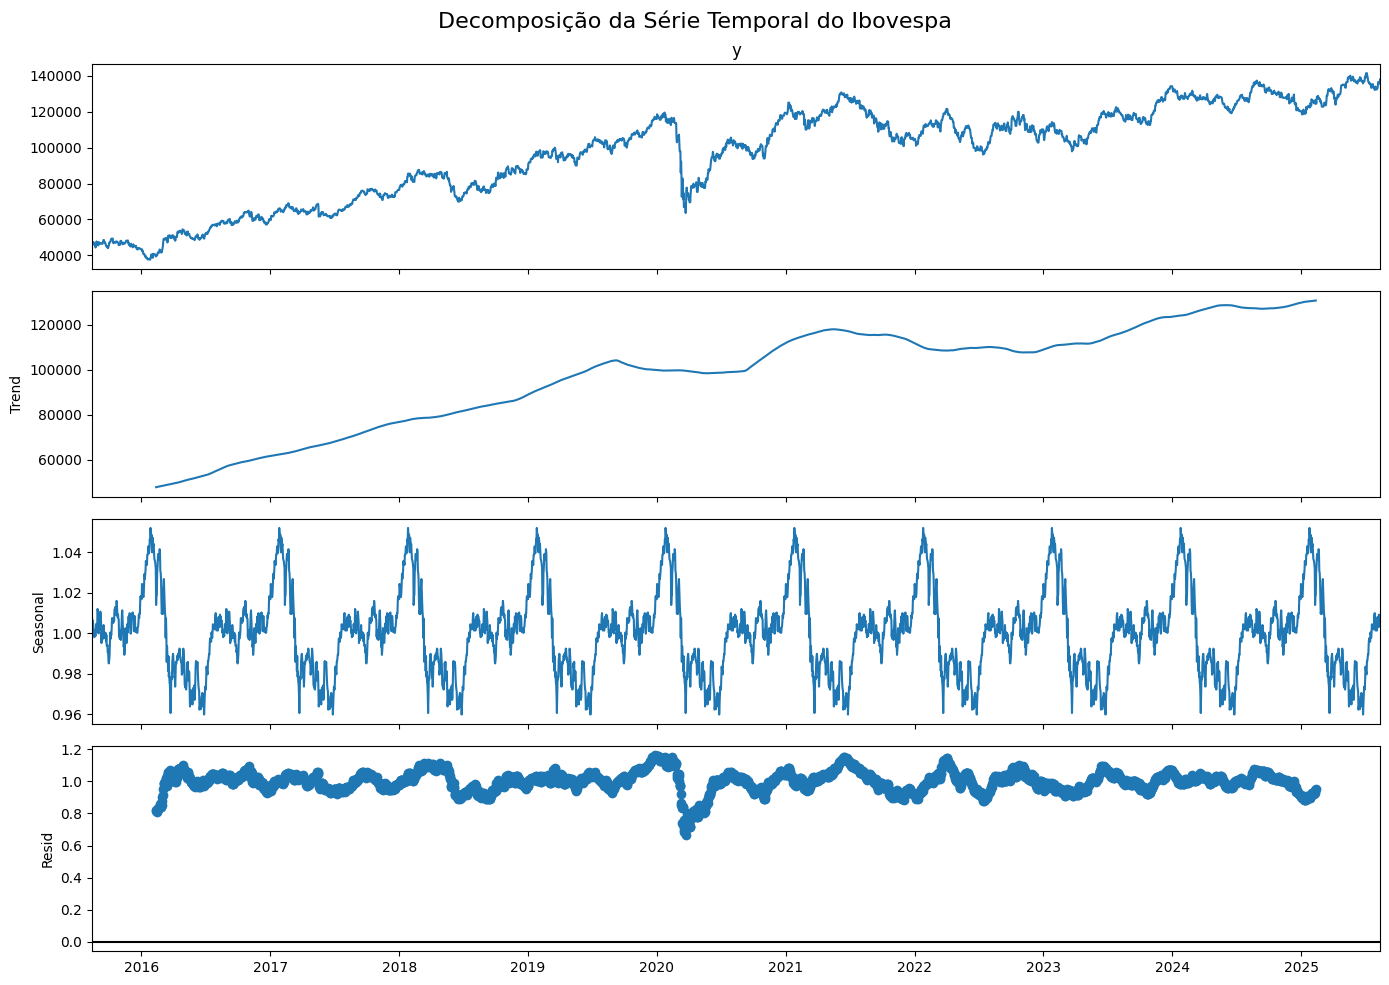

In [13]:
df_pandas = df2.to_pandas() if not isinstance(df2, pd.DataFrame) else df2.copy()

# Garantir a indexação do Dataframe
df_pandas = df_pandas.sort_values("ds")
df_pandas.set_index("ds", inplace=True)

# Decomposição da série
result = seasonal_decompose(df_pandas['y'], model='multiplicative', period=365)


plt.rcParams.update({'figure.figsize': (14, 10)})
result.plot()
plt.suptitle('Decomposição da Série Temporal do Ibovespa', fontsize=16)
plt.tight_layout()
plt.show()


In [14]:
tendencia = result.trend
sazonalidade = result.seasonal
residuo = result.resid

decomposicao = pd.concat([df['ds'], df['y'], tendencia, sazonalidade, residuo], axis=1)
decomposicao.columns = ['Data', 'Ibovespa', 'Tendência', 'Sazonalidade', 'Resíduo']
display(decomposicao.head(15))


,Data,Ibovespa,Tendência,Sazonalidade,Resíduo
0,2015-08-14,47508.0,NaN,NaN,NaN
1,2015-08-15,47508.0,NaN,NaN,NaN
2,2015-08-16,47508.0,NaN,NaN,NaN
3,2015-08-17,47217.0,NaN,NaN,NaN
4,2015-08-18,47451.0,NaN,NaN,NaN
5,2015-08-19,46588.0,NaN,NaN,NaN
6,2015-08-20,46649.0,NaN,NaN,NaN
7,2015-08-21,45720.0,NaN,NaN,NaN
8,2015-08-22,45720.0,NaN,NaN,NaN
9,2015-08-23,45720.0,NaN,NaN,NaN


Para melhor visualização, segue abaixo a plotagem dos resíduos encontrados na base após a decomposição temporal, comparado com os Outliers plotados durante a análise exploratória que foi realizada anteriormente.

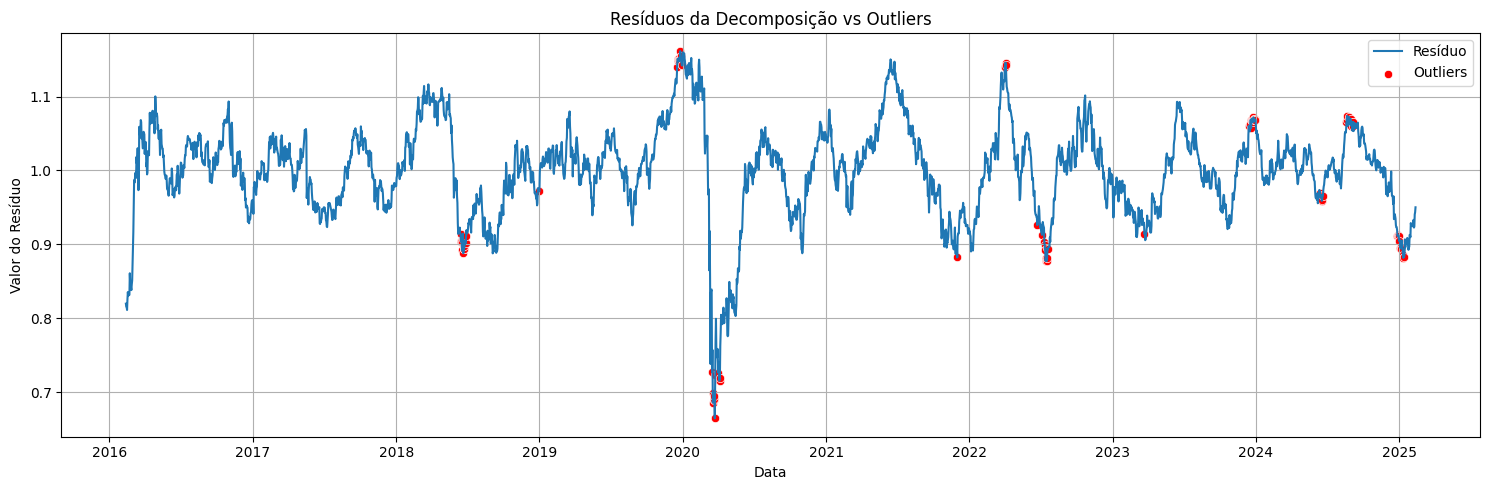

In [15]:
df.reset_index(drop=True, inplace=True)

# Criação da coluna com o ano
df['ano'] = pd.to_datetime(df['ds']).dt.year
df['is_outlier'] = False

# Identificação dos outliers ano a ano
for ano in df['ano'].unique():
    grupo = df[df['ano'] == ano]
    media = grupo['y'].mean()
    desvio = grupo['y'].std()
    lim_sup = media + 2 * desvio
    lim_inf = media - 2 * desvio
    cond = (df['ano'] == ano) & ((df['y'] > lim_sup) | (df['y'] < lim_inf))
    df.loc[cond, 'is_outlier'] = True

# Identificação dos resíduos da decomposição
residuals_df = result.resid.reset_index()
residuals_df.columns = ['ds', 'Resíduo']

df_with_residuals = pd.merge(df, residuals_df, on='ds', how='left')


# Gráfico de resíduos com todos os outliers
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_with_residuals, x='ds', y='Resíduo', label='Resíduo')
sns.scatterplot(data=df_with_residuals[df_with_residuals['is_outlier']], x='ds', y='Resíduo', color='red', label='Outliers')
plt.title('Resíduos da Decomposição vs Outliers')
plt.xlabel('Data')
plt.ylabel('Valor do Resíduo')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Como nosso modelo apresenta uma sazonalidade relevante para ser considerada no modelo de predição, a mesma será mantida neste primeiro momento.

## 6.2 Divisão de Janelas Temporais

Considerando os dados disponíveis, foram divididos em 05 janelas de tempo distintas: <br>
* Últimos 05 anos;
* Últimos 03 anos (36 meses);
* Últimos 02 anos (24 meses);
* Último ano (12 meses);
* Últimos 03 meses (90 dias).<br>


Dessa forma conseguimos avaliar qual período ideal para utilizarmos, considerando a confiabilidade e assertividade do modelo.

In [16]:
janela_5_anos = df.iloc[-1260:].copy()
janela_36m = df.iloc[-750:].copy()
janela_24m = df.iloc[-500:].copy()
janela_12m = df.iloc[-250:].copy()
janela_90d = df.iloc[-90:].copy()

In [17]:
# Definição das janelas de treino e teste

def split_treino_teste(janela, proporcao_teste=0.30):
    tamanho_teste = int(len(janela) * proporcao_teste)
    return janela.iloc[:-tamanho_teste], janela.iloc[-tamanho_teste:]

df_train_5, df_test_5 = split_treino_teste(janela_5_anos)
df_train_36, df_test_36 = split_treino_teste(janela_36m)
df_train_24, df_test_24 = split_treino_teste(janela_24m)
df_train_12, df_test_12 = split_treino_teste(janela_12m)
df_train_90, df_test_90 = split_treino_teste(janela_90d)


print("Shape treino 5 anos:", df_train_5.shape)
print("Shape teste 5 anos:", df_test_5.shape)
print("Shape treino 36 meses:", df_train_36.shape)
print("Shape teste 36 meses:", df_test_36.shape)
print("Shape treino 24 meses:", df_train_24.shape)
print("Shape teste 24 meses:", df_test_24.shape)
print("Shape treino 12 meses:", df_train_12.shape)
print("Shape teste 12 meses:", df_test_12.shape)
print("Shape treino 90 dias:", df_train_90.shape)
print("Shape teste 90 dias:", df_test_90.shape)

Shape treino 5 anos: (882, 6)
Shape teste 5 anos: (378, 6)
Shape treino 36 meses: (525, 6)
Shape teste 36 meses: (225, 6)
Shape treino 24 meses: (350, 6)
Shape teste 24 meses: (150, 6)
Shape treino 12 meses: (175, 6)
Shape teste 12 meses: (75, 6)
Shape treino 90 dias: (63, 6)
Shape teste 90 dias: (27, 6)


# 7.Modelagem

Para a modelagem, serão usados modelos de três tipos distintos:


*   Modelo Estatístico;
*   Modelos de Machine Learning Clássicos;
*   Modelo de Rede Neural.

Essas abordagens serão explicadas com maiores detalhes em seus respectivos tópicos. Mas a primeiro momento, todos os modelos escolhidos não precisaram utilizar os artefatos obtidos na decomposição de série temporal, por se beneficiarem da utilização de sazonalidade.<br>







## 7.1 Modelo Estatístico

Os modelos estatísticos são probabilísticos, ou seja, predizem como os dados são gerados considerando um valor passado + algum ruído.
Dentre eles temos o modelo de Regressão Linear, Regressão Logística, ARIMA e SARIMA (que foi o utilizado neste notebook).<br>

Possui como vantagem a facilidade em desenvolver, funciona bem com amostras com poucos dados e são fáceis de interpretar. Entretanto, é um modelo que pode apresentar pouca aurácia para casos com alto grau de não-linearidade.



### 7.1.1 SARIMA

O modelo SARIMA foi escolhido por considerar sazonalidade em suas predições, não sendo necessário removê-la. Por ser um modelo estatístico. Para modelos desse tipo, são considerados os seguintes parâmetros:

<br><u>Parte não sazonal (p, d, q)</u>
* p: quantos valores históricos serão usados pelo modelo;
* d: quantas diferenças não-sazonais deverão ser utilizadas para remoção de tendência;
* q: quantos erros históricos deverão ser utilizados.


<br><u>Parte sazonal (P, D, Q, S)</u>
* P: o tamanho do período sazonal;
* D: quantos valores sazonais históricos são usados;
* Q: diferenças sazonais ue devem ser aplicadas para remoção do ciclo;
* S: erros sazonais deverão ser utilizados.

<br> Dentre as vantagens desse modelo, está a simplicidade na modelagem, se comporta bem com poucos dados e considera sazonalidades em suas previsões. Entretanto, é um modelo limitado quando tratmos bases com muitas variações de comportamentos ou sazonalidades muito complexas (por exemplo: ciclos que não são bem definidos por tempo, e sim por eventos).


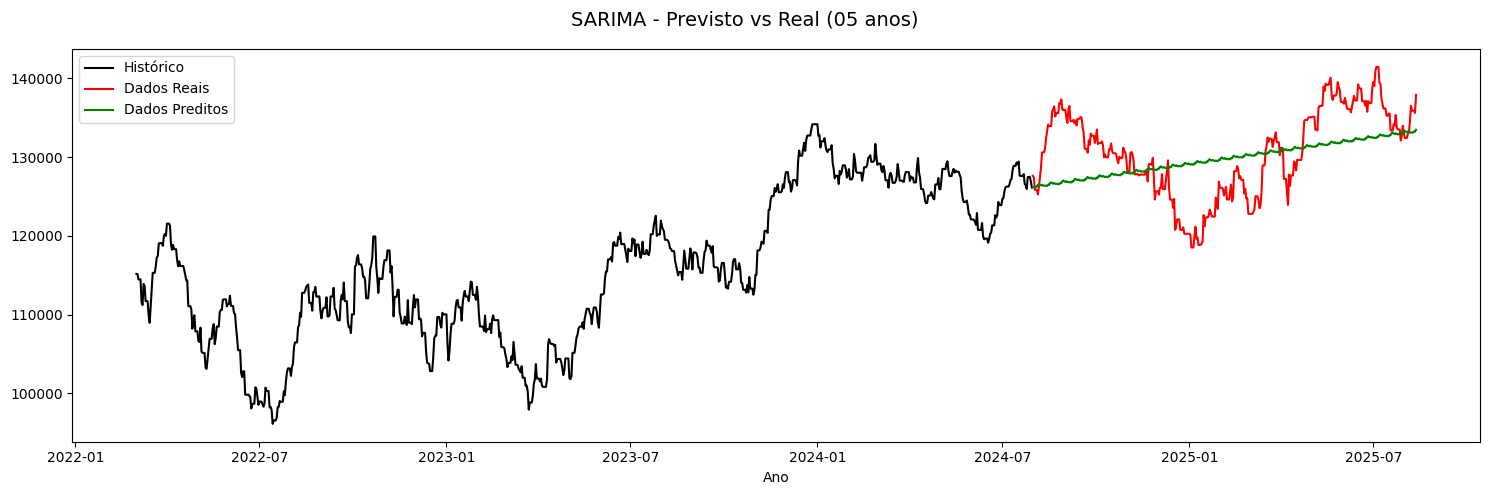

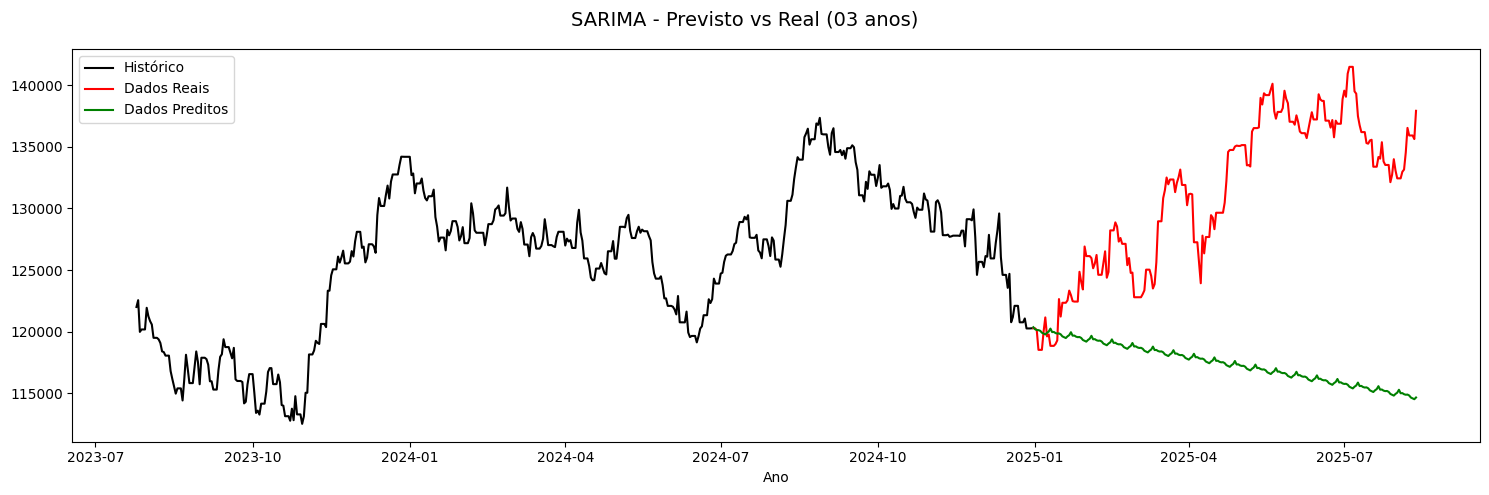

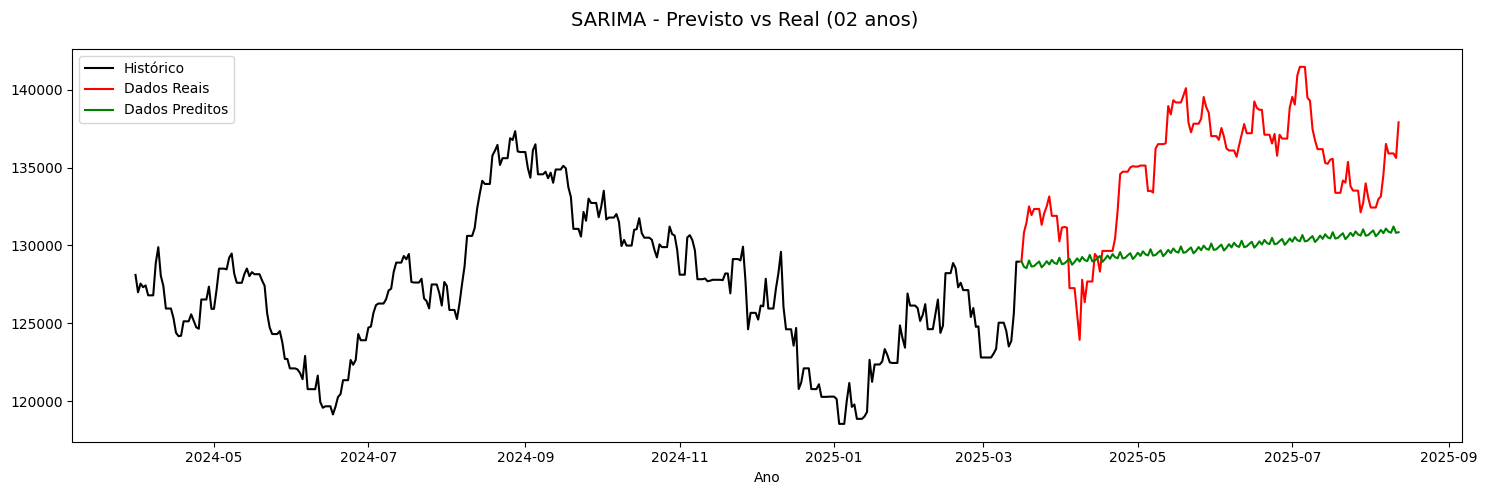

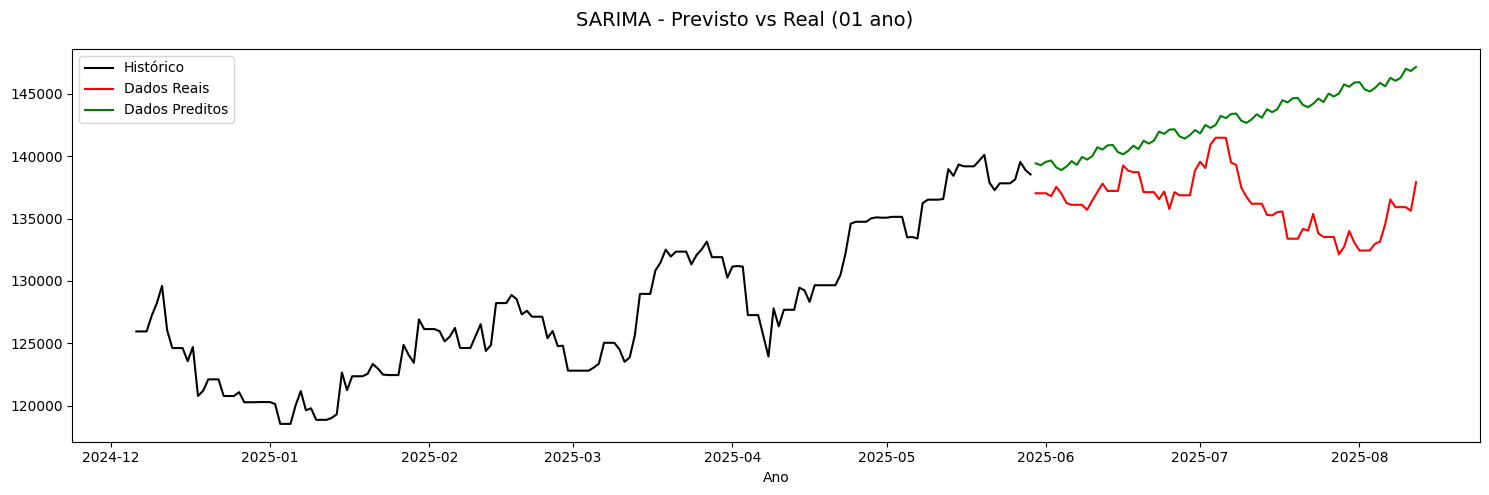

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



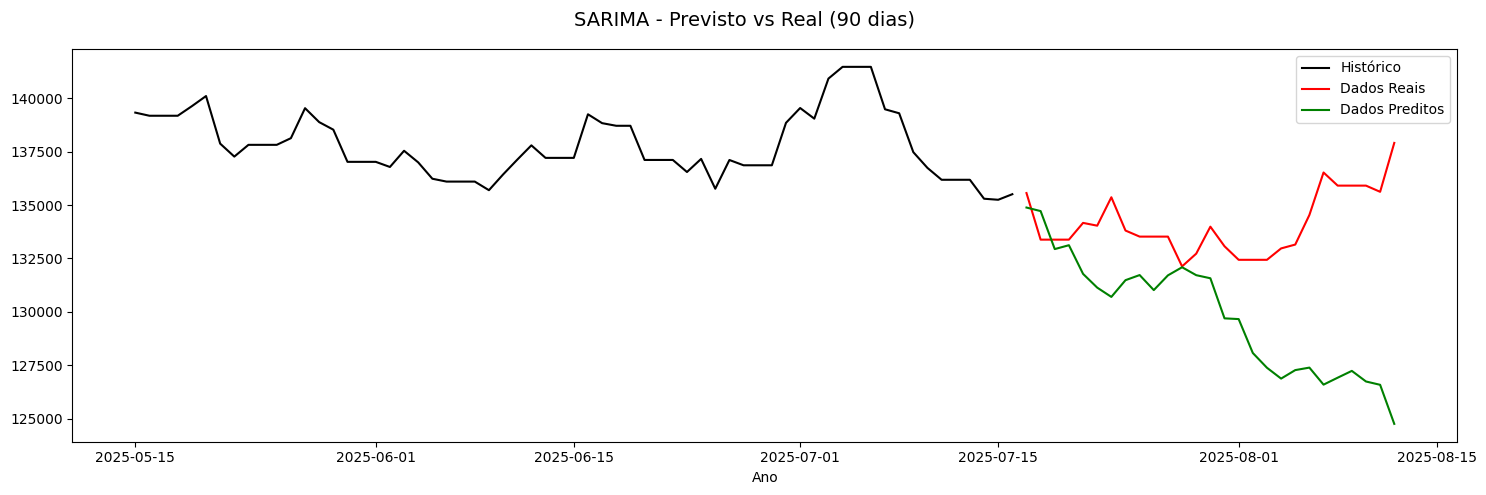

In [18]:
# Criação da função para o cálculo do SARIMA
def sarima_scaled_window(df_train, df_test, order=(5,1,0), seasonal_order=(1,1,1,12), titulo=""):

    # Normalização dos dados
    scaler = MinMaxScaler()
    y_train = df_train['y'].values.reshape(-1, 1)
    y_test  = df_test['y'].values.reshape(-1, 1)

    y_train_scaled = scaler.fit_transform(y_train).ravel()
    y_test_scaled  = scaler.transform(y_test).ravel()

    df_train = df_train.copy()
    df_test  = df_test.copy()
    df_train['y_scaled'] = y_train_scaled
    df_test['y_scaled']  = y_test_scaled

    # Ajuste dos parâmetros sazonais e não sazonais
    model_sarima = SARIMAX(
        y_train_scaled,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    # Ajuste dos intervalo dos dados preditos
    start = len(y_train_scaled)
    end   = start + len(y_test_scaled) - 1
    forecast_scaled = model_sarima.predict(start=start, end=end, dynamic=False).ravel()

    # Métricas para cálculo do MAPE e Assertividade
    mape_scaled = mean_absolute_percentage_error(y_test_scaled, forecast_scaled)
    acc_scaled = 1 - mape_scaled

    forecast_orig = scaler.inverse_transform(forecast_scaled.reshape(-1,1)).ravel()
    y_test_orig   = y_test.ravel()
    y_train_orig  = y_train.ravel()

    mape_orig = mean_absolute_percentage_error(y_test_orig, forecast_orig)
    acc_orig  = 1 - mape_orig

    # Plotagem dos Gráficos
    historico = pd.Series(y_train_orig, index=pd.to_datetime(df_train['ds']))
    reais     = pd.Series(y_test_orig,  index=pd.to_datetime(df_test['ds']))
    preditos  = pd.Series(forecast_orig, index=pd.to_datetime(df_test['ds']))

    fig, ax = plt.subplots(figsize=(15,5))
    fig.suptitle(f"SARIMA - Previsto vs Real {titulo}", fontsize=14)

    treino_ln,   = ax.plot(historico, "black", label="Histórico")
    teste_ln,    = ax.plot(reais,     "red",   label="Dados Reais")
    predicao_ln, = ax.plot(preditos,  "green", label="Dados Preditos")

    ax.legend(handles=[treino_ln, teste_ln, predicao_ln], fontsize=10)
    ax.set_xlabel('Ano', fontsize=10)
    plt.tight_layout()
    plt.show()

    return {
        "model": model_sarima,
        "mape_scaled": float(mape_scaled),
        "acc_scaled": float(acc_scaled),
        "mape_original": float(mape_orig),
        "acc_original": float(acc_orig),
        "forecast_scaled": forecast_scaled,
        "forecast_original": forecast_orig
    }

res_5   = sarima_scaled_window(df_train_5,  df_test_5,  order=(5,1,0), seasonal_order=(1,1,1,12), titulo="(05 anos)")
res_36  = sarima_scaled_window(df_train_36, df_test_36, order=(5,1,0), seasonal_order=(1,1,1,12), titulo="(03 anos)")
res_24  = sarima_scaled_window(df_train_24, df_test_24, order=(5,1,0), seasonal_order=(1,1,1,12), titulo="(02 anos)")
res_12  = sarima_scaled_window(df_train_12, df_test_12, order=(5,1,0), seasonal_order=(1,1,1,12), titulo="(01 ano)")
res_90  = sarima_scaled_window(df_train_90, df_test_90, order=(5,1,0), seasonal_order=(1,1,1,12), titulo="(90 dias)")



Abaixo, é calculado o MAPE (*Mean Absolute Percentage Error*) de cada uma das janelas.
É uma métrica capaz de informar o quão próximo os valores previstos estão dos valores reais. Quanto menor o percentual, mais assertivo é o modelo.

É recomendado um MAPE de até 5%.

In [19]:
print("05 anos - MAPE (orig):", f"{res_5['mape_original']:.2%}")
print("03 anos - MAPE (orig):", f"{res_36['mape_original']:.2%}")
print("02 anos - MAPE (orig):", f"{res_24['mape_original']:.2%}")
print("01 ano  - MAPE (orig):", f"{res_12['mape_original']:.2%}")
print("90 dias - MAPE (orig):", f"{res_90['mape_original']:.2%}")

05 anos - MAPE (orig): 3.38%
03 anos - MAPE (orig): 10.24%
02 anos - MAPE (orig): 3.84%
01 ano  - MAPE (orig): 4.82%
90 dias - MAPE (orig): 3.25%


#### Assertividade SARIMA

A Assertividade pode ser descrita como o conceito contrário ao do MAPE. Enquanto o MAPE traz o valor de Erro Médio, a Assertividade é o valor de Acerto Médio.
Ou seja, podemos calcular como "1 - MAPE".

In [20]:
print("05 anos - Assertividade (orig):", f"{res_5['acc_original']:.2%}")
print("03 anos - Assertividade (orig):", f"{res_36['acc_original']:.2%}")
print("02 anos - Assertividade (orig):", f"{res_24['acc_original']:.2%}")
print("01 ano  - Assertividade (orig):", f"{res_12['acc_original']:.2%}")
print("90 dias - Assertividade (orig):", f"{res_90['acc_original']:.2%}")


05 anos - Assertividade (orig): 96.62%
03 anos - Assertividade (orig): 89.76%
02 anos - Assertividade (orig): 96.16%
01 ano  - Assertividade (orig): 95.18%
90 dias - Assertividade (orig): 96.75%


## 7.2 Modelos ML Clássicos

Nos modelos de *Machine Learning* clássicos, dependendo das atributos considerados durante o processamento, os padrões são aprendidos com os próprios dados disponíveis.
Dentre esses modelos, temos o SVM, Random Forest Regressor (RFR) e Gradient Boosting.<br>

Possui alta sensibilidade para modelos não-lineares, entregando predições confiáveis. Entretanto, podem exigir uma certa calibração nos atributos.



### 7.2.1 Random Forest Regressor

O modelo Random Forest Regressor (RFG) prevê os valores futuros por meio de um conjunto de árvores de decisões. Ou seja, analisa todos os possíveis valores com base no histórico, e retorna como valor final a média de todos esses valores. Dessa forma, os valores tendem a ser mais estáveis e confiáveis.

Tem como vantagens prever de forma automática as interações dos dados que não são lineares, funciona bem para bases de dados com muitos registros, e tem sensibilidade para identificar *outliers* e ruídos históricos. Entretanto, exige maior complexidade para a interpretação, e também podeapresentar *overfitting* nos dados novos (retornando valores muito semelhantes ao passado, e que não necessariamente refletem a realidade dos valores futuros).

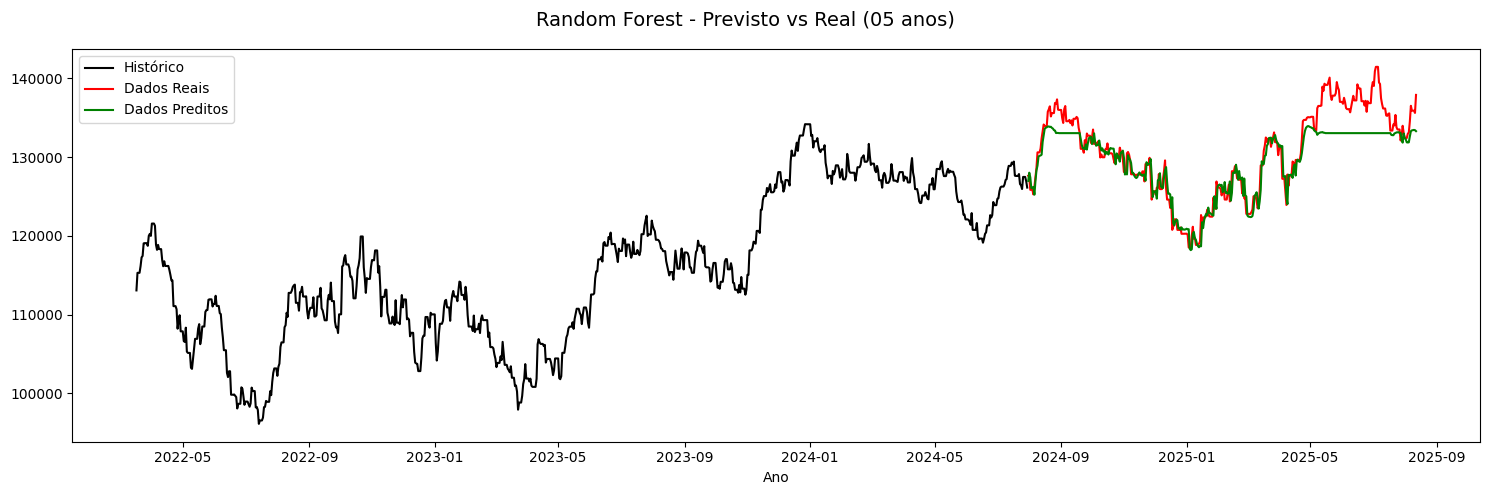

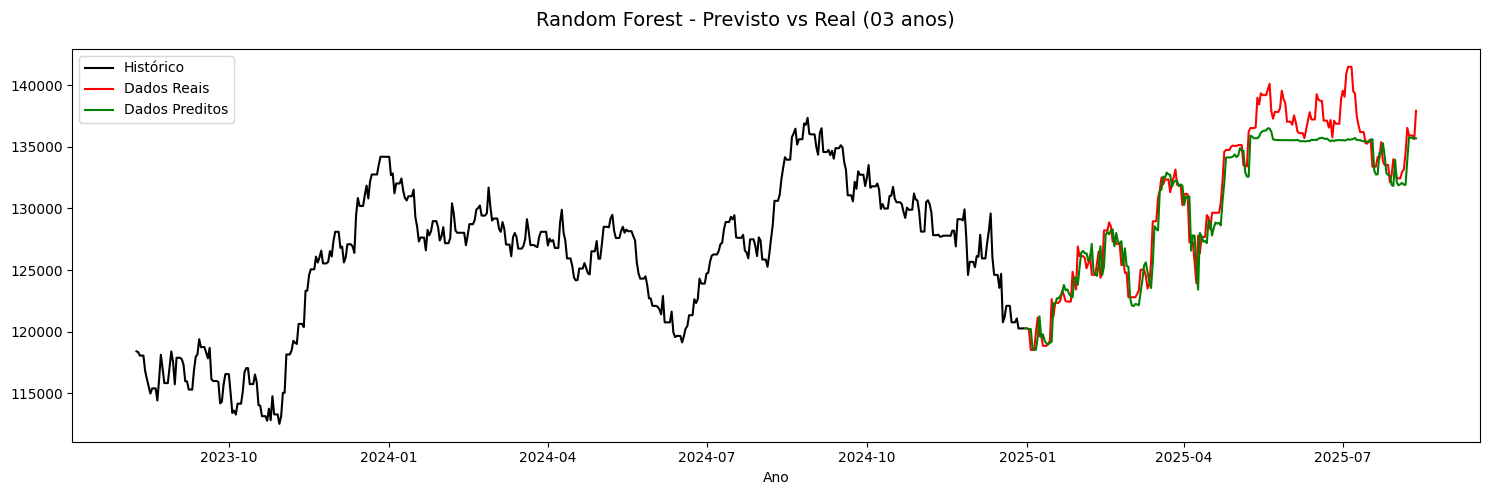

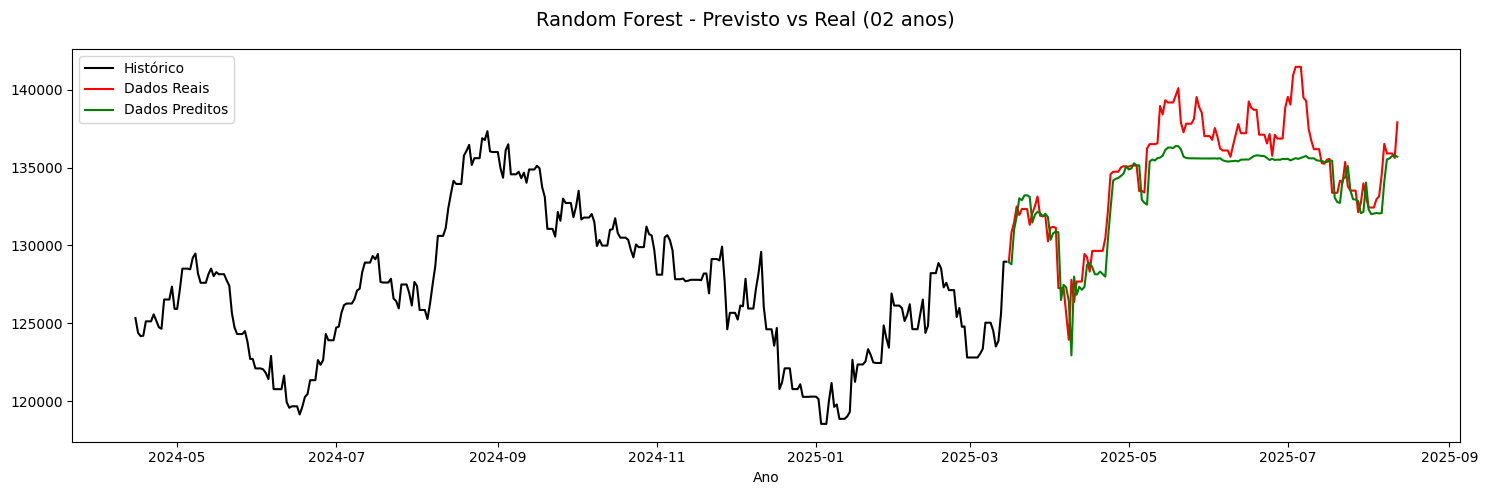

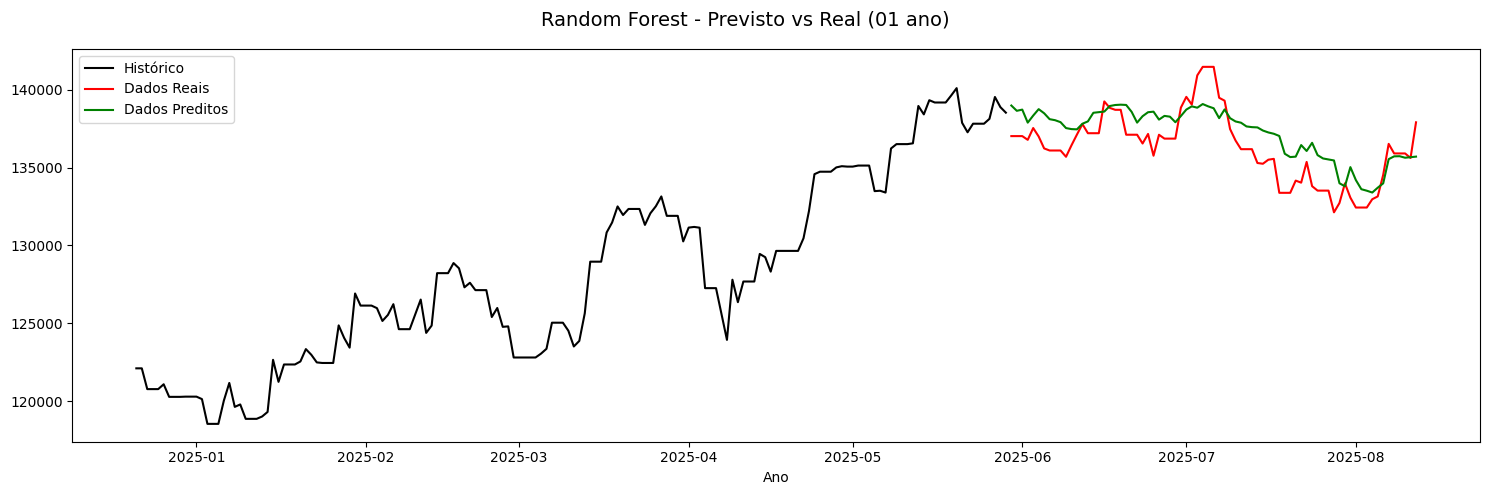

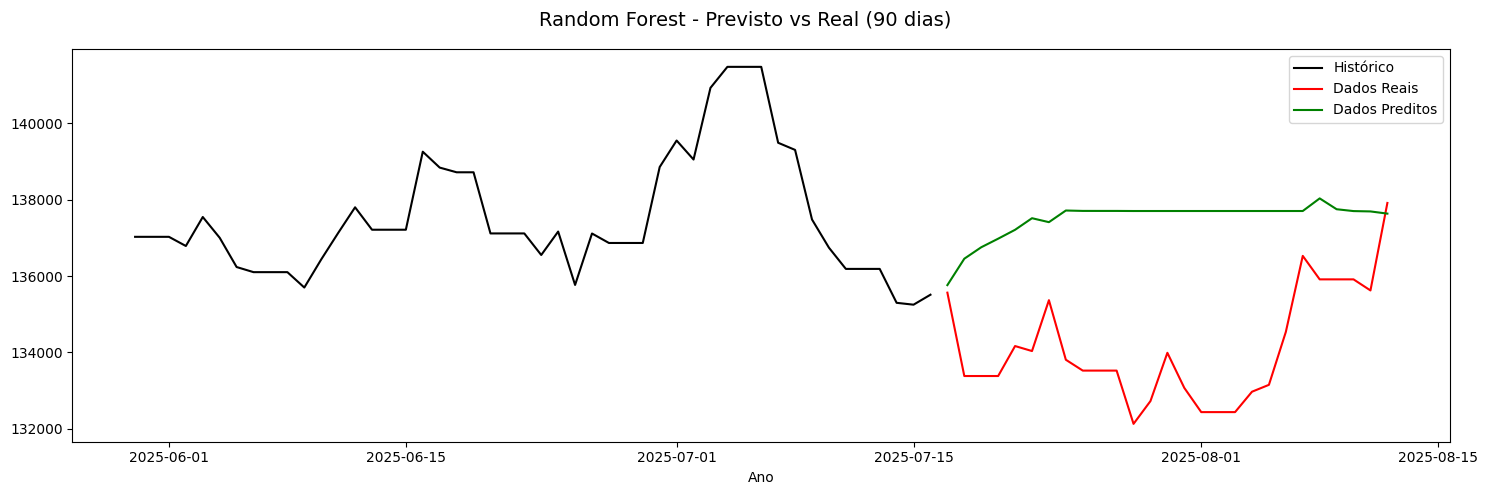

In [21]:
# Criação da função para transformar a série em dados supervisionados
def preparar_lags_e_split(ds_train, ds_test, n_lags=15):

    # Separação dos Dataframes de treino e teste
    df_train = ds_train[['ds', 'y']].copy()
    df_test  = ds_test[['ds', 'y']].copy()

    df_train['__split__'] = 'train'
    df_test['__split__']  = 'test'
    df_all = pd.concat([df_train, df_test], ignore_index=True)

    # Identificar datas passadas dos Dataframes
    df_all['ds'] = pd.to_datetime(df_all['ds'], errors='coerce')
    df_all = df_all.dropna(subset=['ds']).sort_values('ds').reset_index(drop=True)

    # Criar defasagem/ lag
    for lag in range(1, n_lags + 1):
        df_all[f'lag_{lag}'] = df_all['y'].shift(lag)

    df_all = df_all.dropna().reset_index(drop=True)

    # Separação treino e teste
    mask_train = df_all['__split__'] == 'train'
    mask_test  = df_all['__split__'] == 'test'

    feature_cols = [c for c in df_all.columns if c.startswith('lag_')]

    X_train = df_all.loc[mask_train, feature_cols].copy()
    y_train = df_all.loc[mask_train, 'y'].copy()

    X_test  = df_all.loc[mask_test, feature_cols].copy()
    y_test  = df_all.loc[mask_test, 'y'].copy()

    dates_train = df_all.loc[mask_train, 'ds'].copy()
    dates_test  = df_all.loc[mask_test, 'ds'].copy()

    # Definição dos dados com defasagem/lag
    return X_train, y_train, X_test, y_test, dates_train, dates_test

# Função responsável pelo treino, predição e plotagem
def treinar_prever_plot_rf(df_train, df_test, titulo, n_lags=15, n_estimators=300, random_state=42):
    X_train, y_train, X_test, y_test, dates_train, dates_test = preparar_lags_e_split(
        df_train, df_test, n_lags=n_lags
    )

    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Séries
    historico = pd.Series(y_train.values, index=pd.to_datetime(dates_train.values))
    reais     = pd.Series(y_test.values,  index=pd.to_datetime(dates_test.values))
    preditos  = pd.Series(y_pred,         index=pd.to_datetime(dates_test.values))

    # Métricas para cálculo do MAPE e Assertividade
    mape = mean_absolute_percentage_error(reais, preditos)
    acc  = 1 - mape

    # Plotagem dos Gráficos
    fig, ax = plt.subplots(figsize=(15,5))
    fig.suptitle(f"Random Forest - Previsto vs Real {titulo}", fontsize=14)

    treino_ln,   = ax.plot(historico, "black", label="Histórico")
    teste_ln,    = ax.plot(reais,     "red",   label="Dados Reais")
    predicao_ln, = ax.plot(preditos,  "green", label="Dados Preditos")

    ax.legend(handles=[treino_ln, teste_ln, predicao_ln], fontsize=10)
    ax.set_xlabel('Ano', fontsize=10)
    plt.tight_layout()
    plt.show()

    return {"model": model, "mape_original": float(mape), "acc_original": float(acc), "y_pred_teste": preditos}

resultados = {}
resultados["5 anos"]  = treinar_prever_plot_rf(df_train_5,  df_test_5,  titulo="(05 anos)",  n_lags=15)
resultados["36m"]     = treinar_prever_plot_rf(df_train_36, df_test_36, titulo="(03 anos)", n_lags=15)
resultados["24m"]     = treinar_prever_plot_rf(df_train_24, df_test_24, titulo="(02 anos)", n_lags=15)
resultados["12m"]     = treinar_prever_plot_rf(df_train_12, df_test_12, titulo="(01 ano)", n_lags=15)
resultados["90d"]     = treinar_prever_plot_rf(df_train_90, df_test_90, titulo="(90 dias)",  n_lags=15)

Abaixo, segue o MAPE calculado de cada uma das janelas temporais.

In [22]:
for nome, res in resultados.items():
    print(f"{nome}: MAPE = {res['mape_original']:.2%}")

5 anos: MAPE = 1.27%
36m: MAPE = 0.98%
24m: MAPE = 1.11%
12m: MAPE = 1.04%
90d: MAPE = 2.54%


#### Assertividade RFR

In [23]:
for nome, res in resultados.items():
    print(f"{nome}: Assertividade = {res['acc_original']:.2%}")

5 anos: Assertividade = 98.73%
36m: Assertividade = 99.02%
24m: Assertividade = 98.89%
12m: Assertividade = 98.96%
90d: Assertividade = 97.46%


### 7.2.2 Gradient Boosting

É um modelo semelhante ao Random Forest Regressor, sendo a principal diferença a forma em que as árvores de decisão são utilizadas para a prediçao de dados.<br>

Enquanto o modelo anterior era uma média de todos os possíveis dados, o Gradient Boosting é a soma de cada árvore de decisão. O que ocorre é que para cada possível número predito, são calculados os possíveis erros dessa previsão, sendo considerado para  ageração do número seguinte. Em resumo, é como se cada número previsto "aprendesse" com os erro anteriores. Se obtém o número final previsto após repetir várias vezes esse processo.

<br>Tem como vantagens justamente essa melhoria gradual ao longo do processamento, além de interpretar bem dados não lineares e com muitas variáveis. Entretanto, também pode sofrer do processo de *overfitting*.

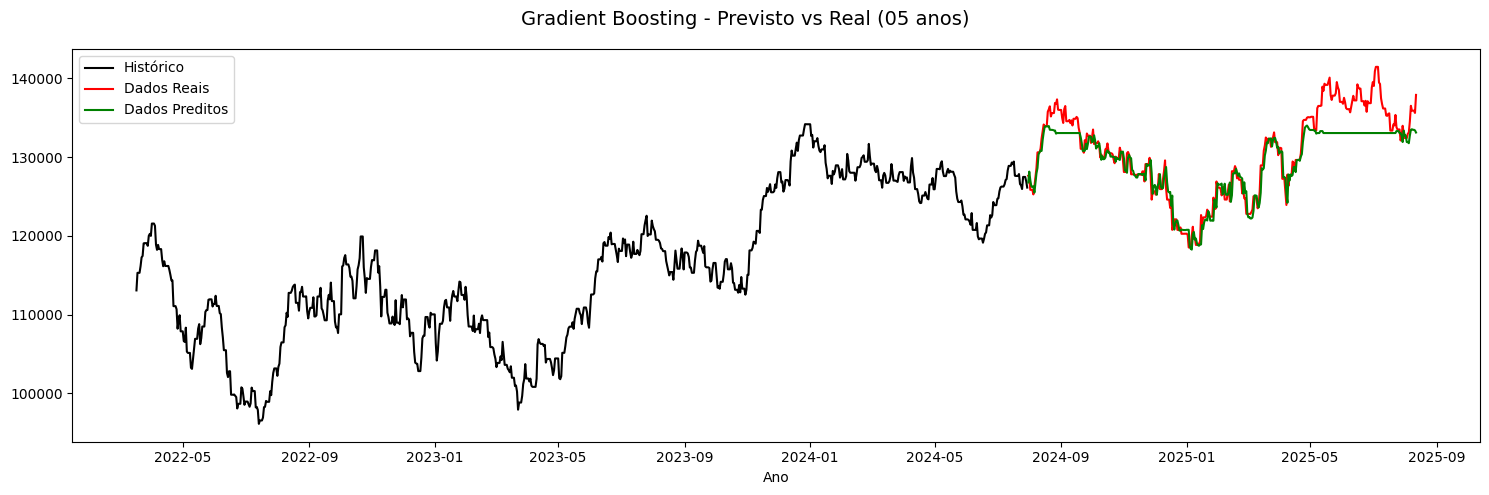

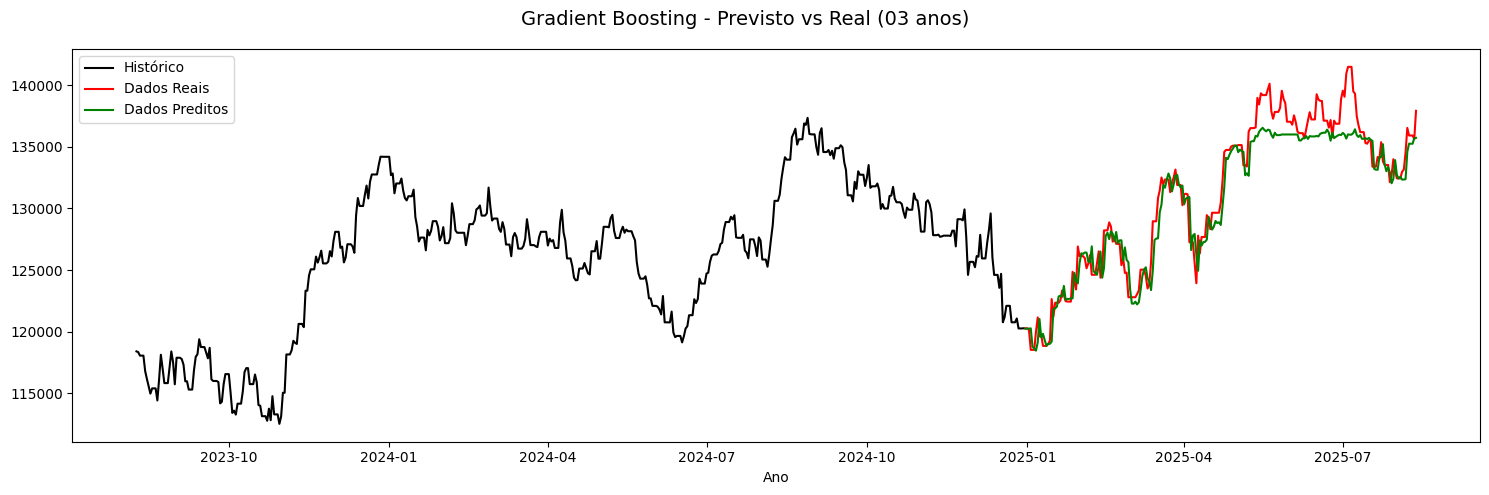

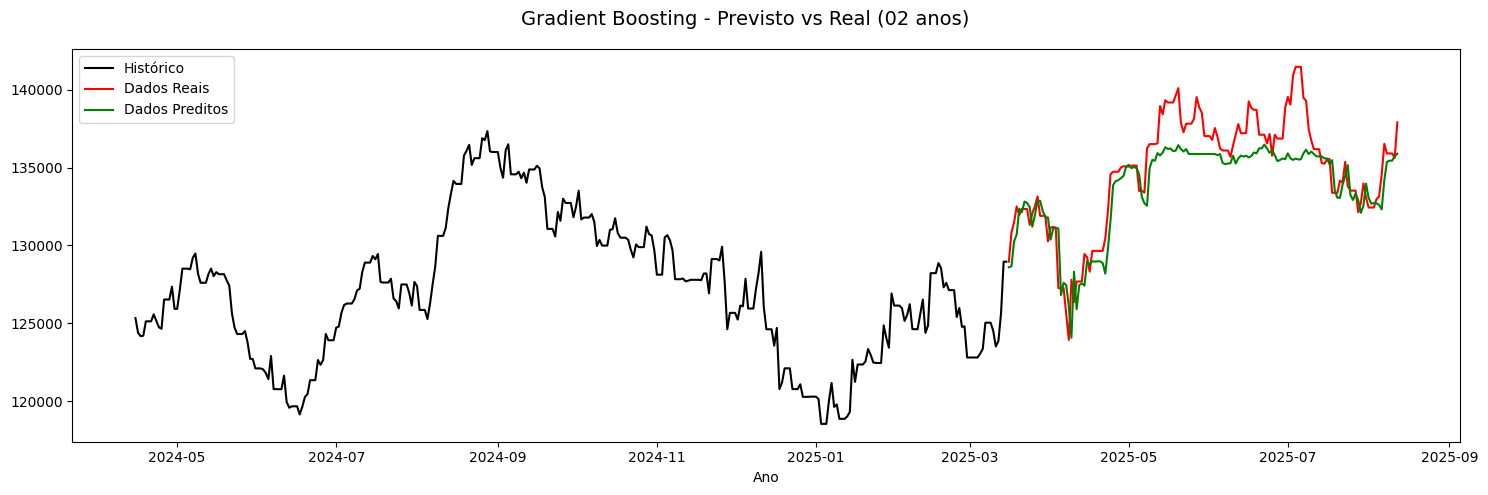

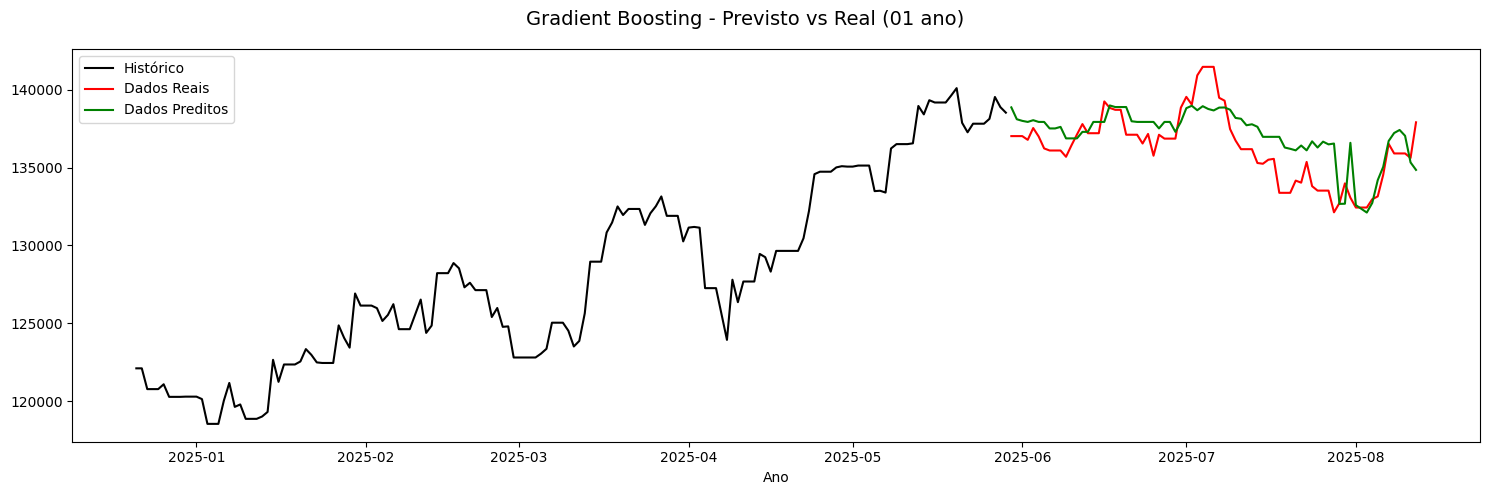

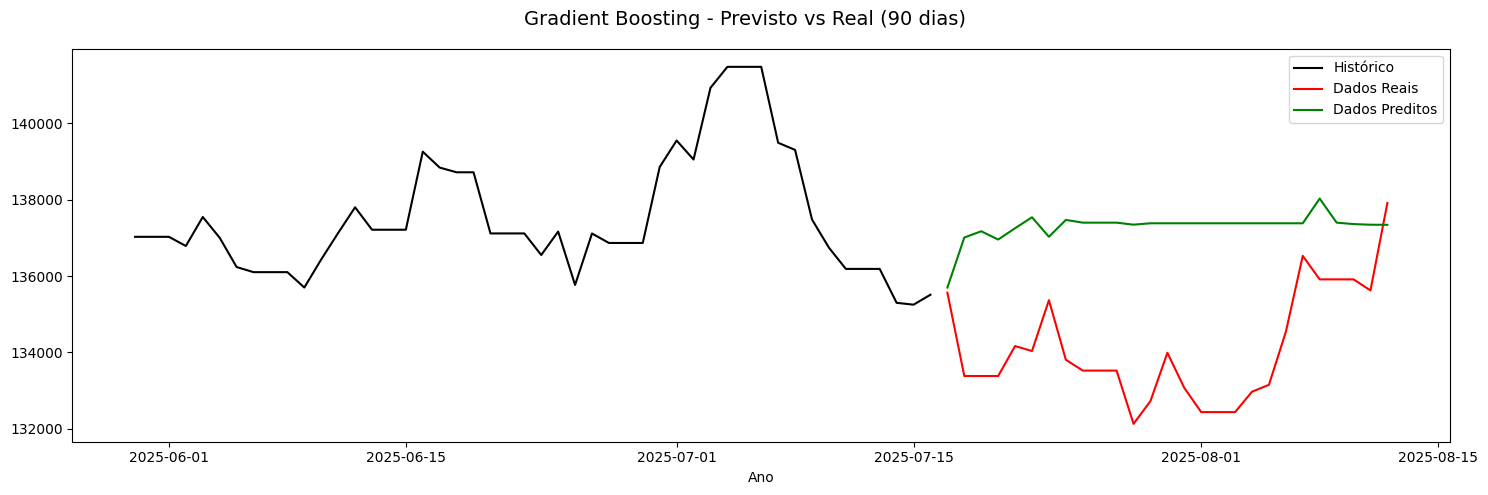

In [24]:
# Definição da função para preparar defasagem e split
def preparar_lags_e_split(ds_train, ds_test, n_lags=15):

    # Separação dos Dataframes de treino e teste
    df_train = ds_train[['ds', 'y']].copy()
    df_test  = ds_test[['ds', 'y']].copy()

    df_train['__split__'] = 'train'
    df_test['__split__']  = 'test'
    df_all = pd.concat([df_train, df_test], ignore_index=True)

    # Identificar datas passadas dos Dataframes
    df_all['ds'] = pd.to_datetime(df_all['ds'], errors='coerce')
    df_all = df_all.dropna(subset=['ds']).sort_values('ds').reset_index(drop=True)

    # Criar defasagem
    for lag in range(1, n_lags + 1):
        df_all[f'lag_{lag}'] = df_all['y'].shift(lag)

    df_all = df_all.dropna().reset_index(drop=True)

    mask_train = df_all['__split__'] == 'train'
    mask_test  = df_all['__split__'] == 'test'

    feature_cols = [c for c in df_all.columns if c.startswith('lag_')]

    # Separação treino e teste
    X_train = df_all.loc[mask_train, feature_cols].copy()
    y_train = df_all.loc[mask_train, 'y'].copy()

    X_test  = df_all.loc[mask_test, feature_cols].copy()
    y_test  = df_all.loc[mask_test, 'y'].copy()

    dates_train = df_all.loc[mask_train, 'ds'].copy()
    dates_test  = df_all.loc[mask_test, 'ds'].copy()

    # Definição dos dados com defasagem/lag
    return X_train, y_train, X_test, y_test, dates_train, dates_test


# Função responsável pelo treino, predição e plotagem
def treinar_prever_plot_gb(df_train, df_test, titulo, n_lags=15, random_state=42):
    X_train, y_train, X_test, y_test, dates_train, dates_test = preparar_lags_e_split(
        df_train, df_test, n_lags=n_lags
    )

    model = GradientBoostingRegressor(random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Séries
    historico = pd.Series(y_train.values, index=pd.to_datetime(dates_train.values))
    reais     = pd.Series(y_test.values,  index=pd.to_datetime(dates_test.values))
    preditos  = pd.Series(y_pred,         index=pd.to_datetime(dates_test.values))

    # Métricas para cálculo do MAPE e Assertividade
    mape = mean_absolute_percentage_error(reais, preditos)
    acc  = 1 - mape

    # Plotagem dos Gráficos
    fig, ax = plt.subplots(figsize=(15,5))
    fig.suptitle(f"Gradient Boosting - Previsto vs Real {titulo}", fontsize=14)

    treino_ln,   = ax.plot(historico, "black", label="Histórico")
    teste_ln,    = ax.plot(reais,     "red",   label="Dados Reais")
    predicao_ln, = ax.plot(preditos,  "green", label="Dados Preditos")

    ax.legend(handles=[treino_ln, teste_ln, predicao_ln], fontsize=10)
    ax.set_xlabel('Ano', fontsize=10)
    plt.tight_layout()
    plt.show()

    return {"model": model, "mape_original": float(mape), "acc_original": float(acc), "y_pred_teste": preditos}

resultados_gb = {}
resultados_gb["5 anos"]  = treinar_prever_plot_gb(df_train_5,  df_test_5,  titulo="(05 anos)",  n_lags=15)
resultados_gb["36m"]     = treinar_prever_plot_gb(df_train_36, df_test_36, titulo="(03 anos)", n_lags=15)
resultados_gb["24m"]     = treinar_prever_plot_gb(df_train_24, df_test_24, titulo="(02 anos)", n_lags=15)
resultados_gb["12m"]     = treinar_prever_plot_gb(df_train_12, df_test_12, titulo="(01 ano)", n_lags=15)
resultados_gb["90d"]     = treinar_prever_plot_gb(df_train_90, df_test_90, titulo="(90 dias)",  n_lags=15)


In [25]:
for nome, res in resultados_gb.items():
    print(f"{nome}: MAPE = {res['mape_original']:.2%}")

5 anos: MAPE = 1.25%
36m: MAPE = 0.90%
24m: MAPE = 1.03%
12m: MAPE = 1.00%
90d: MAPE = 2.41%


#### Assertividade Gradient Boosting

In [26]:
for nome, res in resultados_gb.items():
    print(f"{nome}: Assertividade = {(res['acc_original']):.2%}")

5 anos: Assertividade = 98.75%
36m: Assertividade = 99.10%
24m: Assertividade = 98.97%
12m: Assertividade = 99.00%
90d: Assertividade = 97.59%


## 7.3 Modelo de Rede Neural

Esses modelos apresendem representações de forma automática, sem a necessidade de criar parâmentros como nos modelos de ML Clássicos.
Entre eles, temos modelos destinado a aprender padrões de imagens CNN) e LSTM. <br>

São muito confiáveis para dados não-lineares e bases com muitos registros históricos, além de interpretarem bem dados complexos. Etretanto, exige muito tempo e memória para processamento.

### 7.3.1 LSTM

O modelo LSTM (Long Short-Term Memory) é ideal ara trabalhar com dados sequências, e é capaz de armazenar informações a longo prazo. Essa característica permite que as redes neurais aprendam relações e padrões complexos, incluindo sazonalidades e tendências, retornando valores com alta confiabilidade.

Entre suas vantagens estão o aprendizado a longo prazo e capacidade de entender bases complexas. Entretanto, além de ser um modelo de difícil interpretação, também sofre o risco de *overfitting*.


---



A primeira etapa do processamento é manter os resultados mais
semelhantes possíveis a cada execução, pois eles podem variar.
A solução encontrada foi fixar um valor de semente aleatória.

In [27]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

A próxima etapa é separar as sequências, para que os dados sejam normalizados. Para este modelo em específico, é necessária a normalização para garantir que todos os valores terão pesos semelhantes e na mesma escala, aumentando a confiabilidade no processo de aprendizado do LSTM.

In [28]:
# Definição da função para preparar sequências de LSTM
def preparar_sequencias_lstm(df_train, df_test, n_lags=30):

    # Separação dos Dataframes de treino e teste
    a = df_train[['ds','y']].copy(); a['__split__']='train'
    b = df_test [['ds','y']].copy(); b['__split__']='test'
    df_all = pd.concat([a, b], ignore_index=True)

    # Identificar datas passadas dos Dataframes
    df_all['ds'] = pd.to_datetime(df_all['ds'], errors='coerce')
    df_all = df_all.dropna(subset=['ds']).sort_values('ds').reset_index(drop=True)

    # Ajuste do scaler exclusivamente para o treino
    train_mask = df_all['__split__']=='train'
    y_train_fit = df_all.loc[train_mask, 'y'].values.reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(y_train_fit)

    # Normalização da série
    y_all_scaled = scaler.transform(df_all['y'].values.reshape(-1,1)).ravel()

    # Construção de janelas deslizantes
    X_seq, y_seq, target_dates, target_split = [], [], [], []
    y_arr = y_all_scaled
    for i in range(n_lags, len(y_arr)):
        X_seq.append(y_arr[i-n_lags:i])
        y_seq.append(y_arr[i])
        target_dates.append(df_all['ds'].iloc[i])
        target_split.append(df_all['__split__'].iloc[i])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

    # Separação treino e teste
    target_split = np.array(target_split)
    dates = np.array(target_dates)

    X_train = X_seq[target_split=='train']
    y_train = y_seq[target_split=='train']
    dates_train = dates[target_split=='train']

    X_test  = X_seq[target_split=='test']
    y_test  = y_seq[target_split=='test']
    dates_test = dates[target_split=='test']

    return X_train, y_train, X_test, y_test, dates_train, dates_test, scaler

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



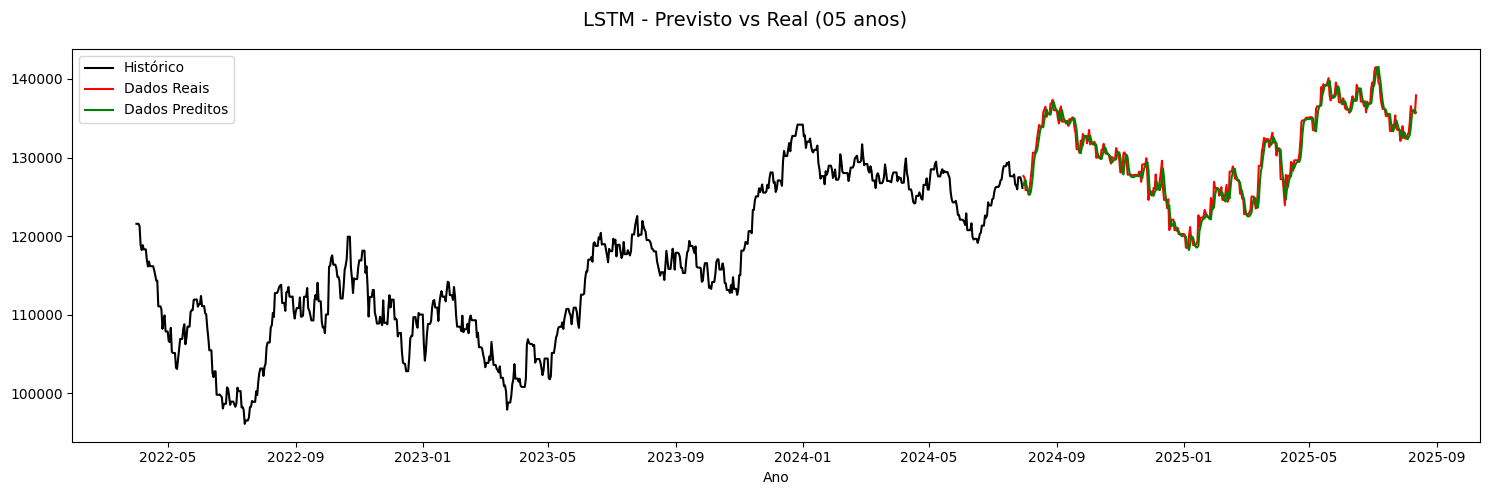

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



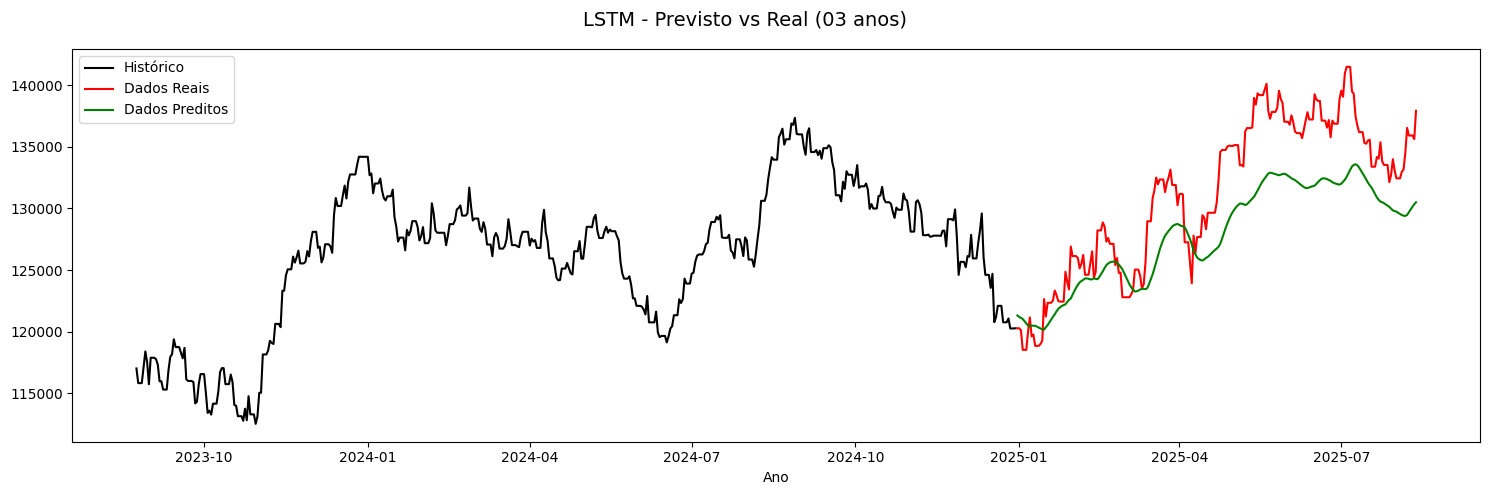

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



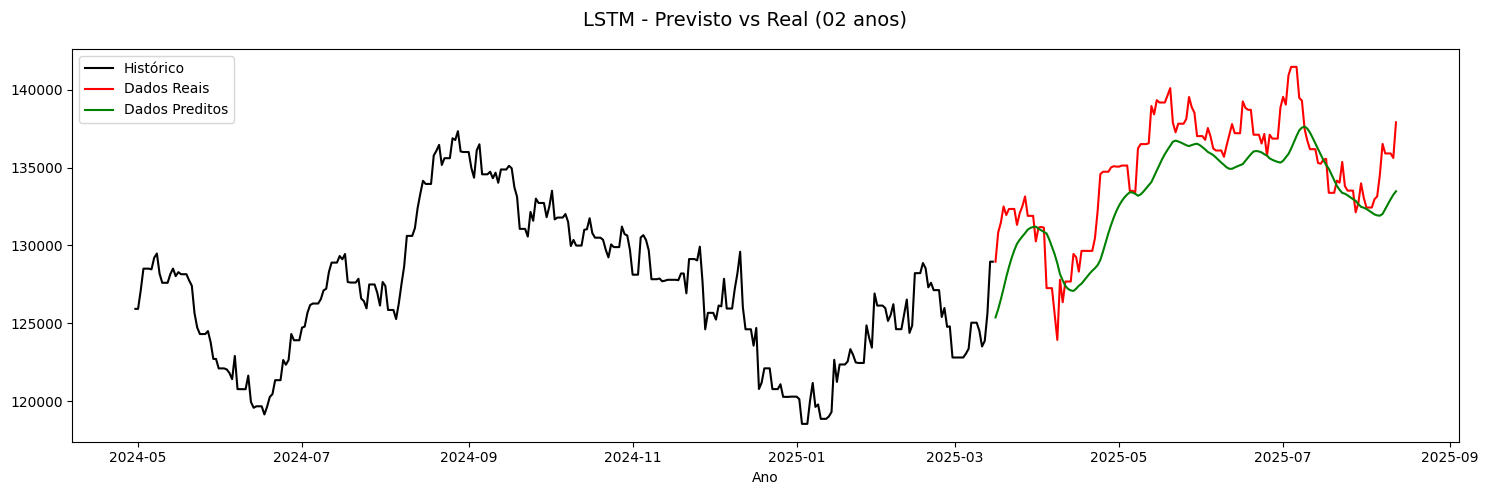

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



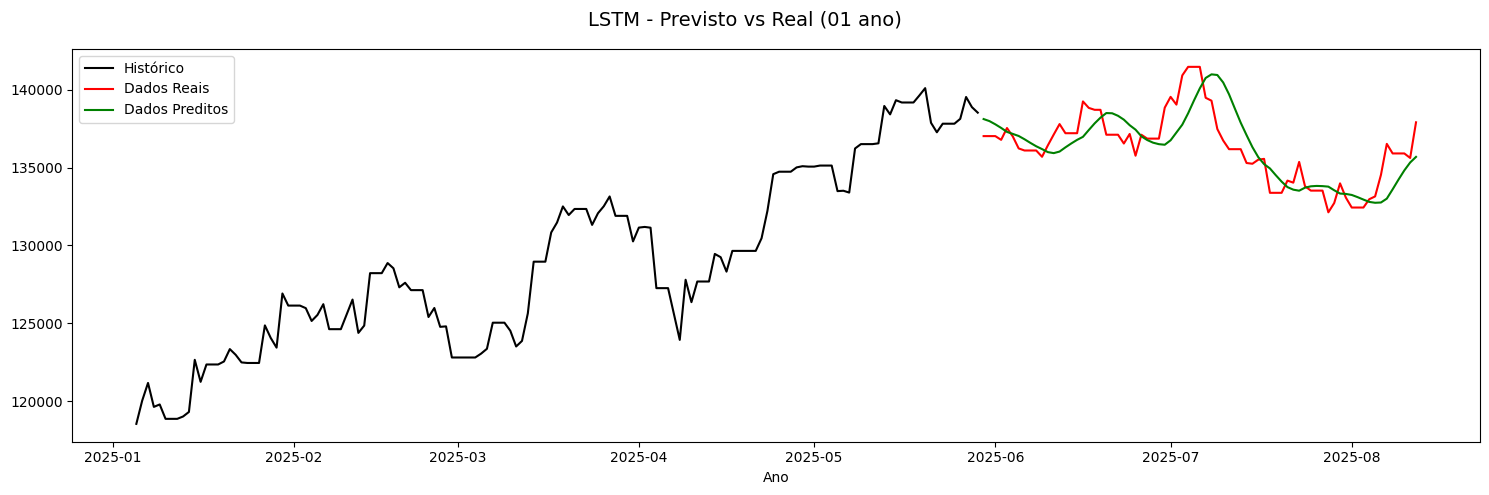

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



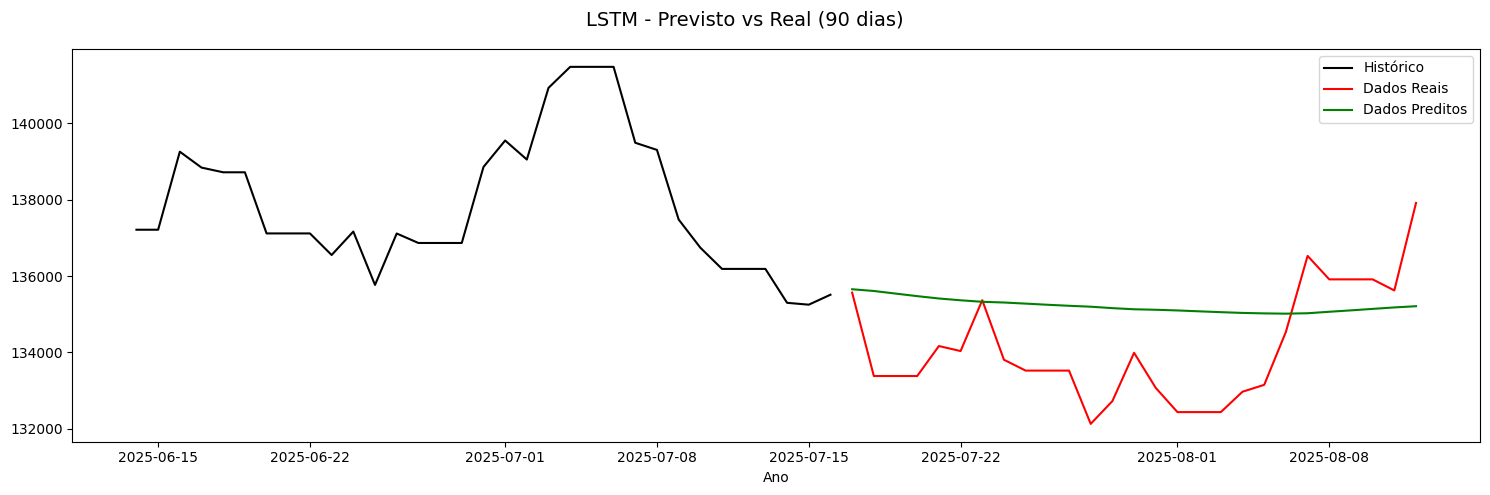

In [29]:
# Função responsável pelo treino, predição e plotagem
def treinar_prever_plot_lstm(df_train, df_test, titulo,
                             n_lags=30, units=64, epochs=100, batch_size=32, patience=10):

    X_train, y_train, X_test, y_test, dates_train, dates_test, scaler = preparar_sequencias_lstm(
        df_train, df_test, n_lags=n_lags
    )

    # Modelo LSTM
    model = Sequential([
        LSTM(units, input_shape=(n_lags, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    # Treino
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # Previsões no TESTE (em escala normalizada)
    y_pred_test_scaled = model.predict(X_test, verbose=0).ravel()

    # Inverter escala para cálculo do MAPE
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
    y_test_orig  = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_orig  = scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

    # Séries para plotagem
    historico = pd.Series(y_train_orig, index=pd.to_datetime(dates_train))
    reais     = pd.Series(y_test_orig,  index=pd.to_datetime(dates_test))
    preditos  = pd.Series(y_pred_orig,  index=pd.to_datetime(dates_test))

    # Métricas para cálculo do MAPE e Assertividade
    mape = mean_absolute_percentage_error(reais, preditos)
    acc  = 1 - mape

    # Plotagem dos gráficos
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(f"LSTM - Previsto vs Real {titulo}", fontsize=14)

    treino_ln,   = ax.plot(historico, "black", label="Histórico")
    teste_ln,    = ax.plot(reais,     "red",   label="Dados Reais")
    predicao_ln, = ax.plot(preditos,  "green", label="Dados Preditos")

    ax.legend(handles=[treino_ln, teste_ln, predicao_ln], fontsize=10)
    ax.set_xlabel('Ano', fontsize=10)
    plt.tight_layout()
    plt.show()

    return {
        "model": model,
        "mape_original": float(mape),
        "acc_original": float(acc),
        "y_pred_teste": preditos
    }

resultados_lstm = {}
resultados_lstm["5 anos"]  = treinar_prever_plot_lstm(df_train_5,  df_test_5,  titulo="(05 anos)",
                                                      n_lags=30, units=64, epochs=100, batch_size=32, patience=10)
resultados_lstm["36m"]     = treinar_prever_plot_lstm(df_train_36, df_test_36, titulo="(03 anos)",
                                                      n_lags=30, units=64, epochs=100, batch_size=32, patience=10)
resultados_lstm["24m"]     = treinar_prever_plot_lstm(df_train_24, df_test_24, titulo="(02 anos)",
                                                      n_lags=30, units=64, epochs=100, batch_size=32, patience=10)
resultados_lstm["12m"]     = treinar_prever_plot_lstm(df_train_12, df_test_12, titulo="(01 ano)",
                                                      n_lags=30, units=64, epochs=100, batch_size=32, patience=10)
resultados_lstm["90d"]     = treinar_prever_plot_lstm(df_train_90, df_test_90, titulo="(90 dias)",
                                                      n_lags=30, units=64, epochs=100, batch_size=32, patience=10)

In [30]:
for nome, res in resultados_lstm.items():
    print(f"{nome}: MAPE = {res['mape_original']:.2%}")

5 anos: MAPE = 0.61%
36m: MAPE = 2.70%
24m: MAPE = 1.50%
12m: MAPE = 0.87%
90d: MAPE = 1.22%


#### Assertividade LSTM

In [31]:
for nome, res in resultados_lstm.items():
    print(f"{nome}: Assertividade = {res['acc_original']:.2%}")

5 anos: Assertividade = 99.39%
36m: Assertividade = 97.30%
24m: Assertividade = 98.50%
12m: Assertividade = 99.13%
90d: Assertividade = 98.78%


# 8.Conclusão

Com exceção do modelo SARIMA, os demais apresentaram boas previsões quando comparamos os valores de <u>testes x previstos</u>, apresentando assertividades acima de 95%.<br>

Para a previsão de pontos IBOVESPA dos  próximos 15 dias, serão plotados nos modelos e janelas que apresentaram melhores desempenhos no quesito confiabilidade. São eles:
* LSTM (05 anos): 99,39% de assertividade;
* Gradient Boosting (03 anos): 99,10% de assertividade;
* Random Forest Regressor (03 anos): 99,02% de assertividade. <br><br>

Os valores de assertividade expressos acima, referem-se à ultima execução do notebook em 12/08/2025. Por se tratar de uma base que é alimentada com novos dados diariamente, os números são passíveis de pequenas variações.




## 8.1 Plotagem de valores futuros

Considerando os modelos já testados, segue a demonstração da previsão dos próximos 15 dias para o 03 que obtiveram maior assertividade.

### 8.1.1 LSTM | Janela de 05 anos

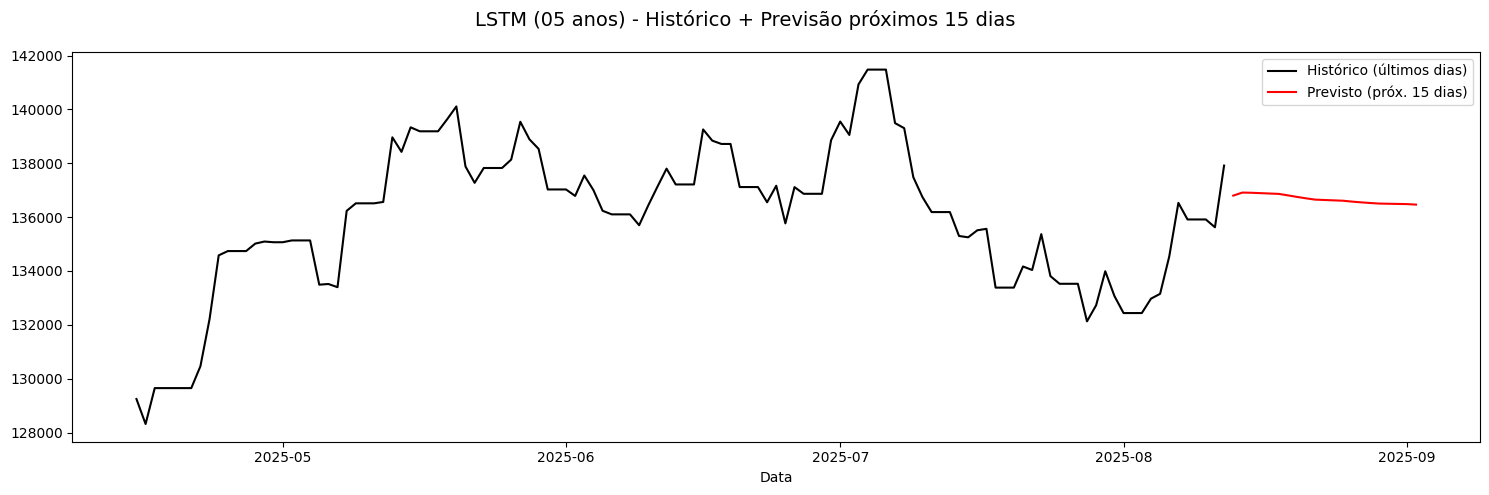

,DATA,PONTOS IBOVESPA PREVISTO
0,13/08/2025,136798.343750
1,14/08/2025,136911.281250
2,15/08/2025,136903.890625
3,18/08/2025,136861.921875
4,19/08/2025,136806.703125
5,20/08/2025,136749.171875
6,21/08/2025,136695.640625
7,22/08/2025,136648.640625
8,25/08/2025,136608.859375
9,26/08/2025,136575.515625


In [32]:
# Parâmetros (mesmo n_lags do treino da LSTM 5 anos)
n_lags_used = 30
periodos_futuros = 15
usar_dias_uteis = True

# Recuperar modelo e scaler da janela de 05 anos
model_5y = resultados_lstm["5 anos"]["model"]

# Obtenção do scaler sem retreinar o modelo
_, _, _, _, _, _, scaler_5y = preparar_sequencias_lstm(df_train_5, df_test_5, n_lags=n_lags_used)

# Série completa da janela 05 anos (treino + teste)
df_5_all = pd.concat([df_train_5[['ds','y']], df_test_5[['ds','y']]], ignore_index=True)
df_5_all['ds'] = pd.to_datetime(df_5_all['ds'], errors='coerce')
df_5_all = df_5_all.dropna(subset=['ds']).sort_values('ds').reset_index(drop=True)

# Última janela (n_lags) para iniciar a previsão
ultimos_n = df_5_all['y'].tail(n_lags_used).values.reshape(-1, 1)
janela_scaled = scaler_5y.transform(ultimos_n).ravel()

# Previsão dos próximos 15 dias
preds_scaled = []
for _ in range(periodos_futuros):
    X = janela_scaled.reshape(1, n_lags_used, 1)
    yhat_scaled = model_5y.predict(X, verbose=0).ravel()[0]
    preds_scaled.append(yhat_scaled)

    janela_scaled = np.append(janela_scaled[1:], yhat_scaled)


preds = scaler_5y.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

# Geração de datas futuras a partir da última data com dados
last_ds = df_5_all['ds'].iloc[-1]
if usar_dias_uteis:
    futuras_ds = pd.bdate_range(start=last_ds + BDay(1), periods=periodos_futuros)
else:
    futuras_ds = pd.date_range(start=last_ds + pd.Timedelta(days=1), periods=periodos_futuros, freq='D')

df_future_15 = pd.DataFrame({"ds": futuras_ds, "y_previsto": preds})

df_future_15_fmt = df_future_15.copy()

# Renomear coluna da tabela com dados futuros
df_future_15_fmt = df_future_15_fmt.rename(
    columns={
        "ds": "DATA",
        "y_previsto": "PONTOS IBOVESPA PREVISTO"
    }
)

# Ajuste de Data para o formato DD/MM/AAAA e casas decimais dos pontos IBOV
df_future_15_fmt["DATA"] = pd.to_datetime(df_future_15_fmt["DATA"]).dt.strftime("%d/%m/%Y")
df_future_15_fmt["PONTOS IBOVESPA PREVISTO"] = df_future_15_fmt["PONTOS IBOVESPA PREVISTO"].round(3)


# Plotagem dos Gráficos
janela_contexto = 120
hist_ctx = df_5_all.tail(janela_contexto).copy()

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle(
    f"LSTM (05 anos) - Histórico + Previsão próximos {periodos_futuros} dias",
    fontsize=14
)
hist_ln, = ax.plot(pd.to_datetime(hist_ctx['ds']), hist_ctx['y'], "black", label="Histórico (últimos dias)")
fut_ln,  = ax.plot(df_future_15['ds'], df_future_15['y_previsto'], "red", label="Previsto (próx. 15 dias)")
ax.legend(handles=[hist_ln, fut_ln], fontsize=10)
ax.set_xlabel("Data", fontsize=10)
plt.tight_layout()
plt.show()


# Visualização da tabela com os valores futuros
display(df_future_15_fmt)

Abaixo, segue a assertividade calculada para esse modelo.

In [33]:
acc5 = resultados_lstm["5 anos"]["acc_original"]
print(f"Assertividade: {acc5:.2%}")

Assertividade: 99.39%


### 8.1.2 Gradient Boosting | Janela de 03 anos

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:27

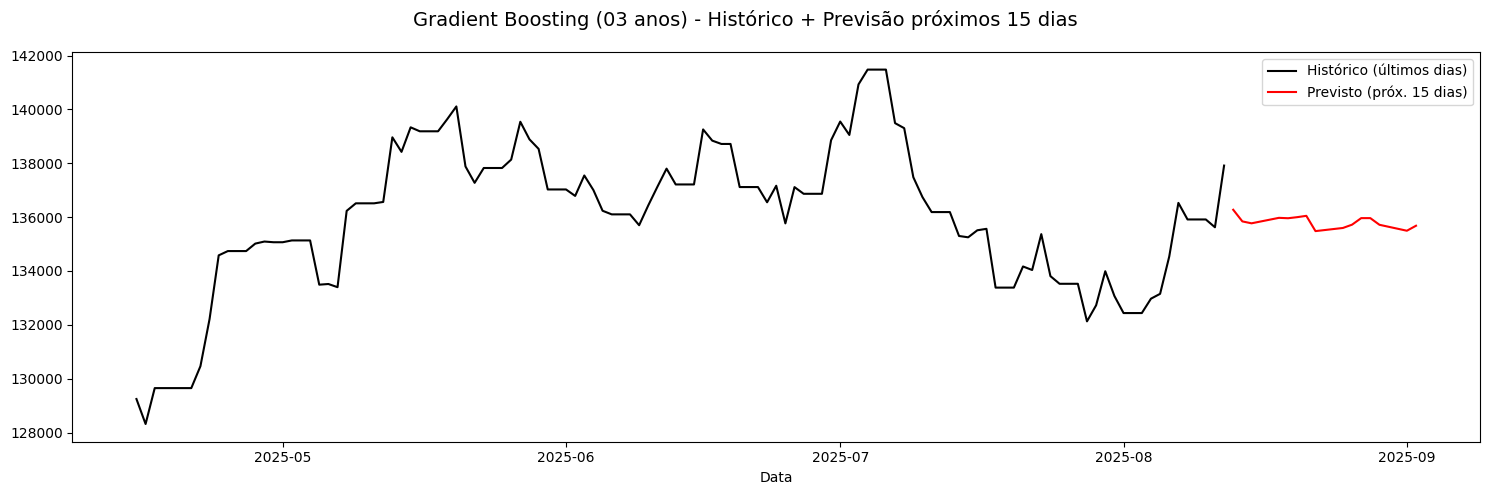

,DATA,PONTOS IBOVESPA PREVISTO
0,13/08/2025,136273.506
1,14/08/2025,135840.887
2,15/08/2025,135769.499
3,18/08/2025,135973.031
4,19/08/2025,135958.512
5,20/08/2025,135998.370
6,21/08/2025,136047.458
7,22/08/2025,135480.353
8,25/08/2025,135596.880
9,26/08/2025,135719.207


In [34]:
# Parâmetros (mesmos n_lags utilizados para o treino de 03 anos)
n_lags_used = 15
periodos_futuros = 15
usar_dias_uteis = True
janela_contexto = 120

# Recuperação do modelo treinado
model_36m = resultados_gb["36m"]["model"]

# Série completa da janela de 03 anos (treino + teste)
df_36_all = pd.concat([df_train_36[['ds','y']], df_test_36[['ds','y']]], ignore_index=True)
df_36_all['ds'] = pd.to_datetime(df_36_all['ds'], errors='coerce')
df_36_all = df_36_all.dropna(subset=['ds']).sort_values('ds').reset_index(drop=True)

# Última janela (n_lags) para iniciar a previsão
janela_y = df_36_all['y'].values[-n_lags_used:].astype(float)

# Previsão dos próximos 15 dias
preds = []
for _ in range(periodos_futuros):
    features = np.array([janela_y[-i] for i in range(1, n_lags_used + 1)], dtype=float).reshape(1, -1)
    yhat = model_36m.predict(features)[0]
    preds.append(yhat)
    janela_y = np.append(janela_y, yhat)[-n_lags_used:]

preds = np.array(preds)

# Geração de datas futuras a partir da última data com dados
last_ds = df_36_all['ds'].iloc[-1]
if usar_dias_uteis:
    futuras_ds = pd.bdate_range(start=last_ds + BDay(1), periods=periodos_futuros)
else:
    futuras_ds = pd.date_range(start=last_ds + pd.Timedelta(days=1), periods=periodos_futuros, freq='D')

df_future_15 = pd.DataFrame({"ds": futuras_ds, "y_previsto": preds})

# Plotagem dos Gráficos
hist_ctx = df_36_all.tail(janela_contexto).copy()

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle(
    f"Gradient Boosting (03 anos) - Histórico + Previsão próximos {periodos_futuros} dias",
    fontsize=14
)
ax.plot(pd.to_datetime(hist_ctx['ds']), hist_ctx['y'], "black", label="Histórico (últimos dias)")
ax.plot(df_future_15['ds'], df_future_15['y_previsto'], "red", label="Previsto (próx. 15 dias)")
ax.legend(fontsize=10)
ax.set_xlabel("Data", fontsize=10)
plt.tight_layout()
plt.show()

# Tabela formatada
df_future_15_fmt = df_future_15.rename(
    columns={"ds": "DATA", "y_previsto": "PONTOS IBOVESPA PREVISTO"}
).copy()
df_future_15_fmt["DATA"] = pd.to_datetime(df_future_15_fmt["DATA"]).dt.strftime("%d/%m/%Y")
df_future_15_fmt["PONTOS IBOVESPA PREVISTO"] = df_future_15_fmt["PONTOS IBOVESPA PREVISTO"].round(3)

display(df_future_15_fmt)

Abaixo, segue a assertividade calculada para esse modelo.

In [35]:
acc36 = resultados_gb["36m"]["acc_original"]
print(f"Assertividade: {acc36:.2%}")


Assertividade: 99.10%


### 8.1.3 Random Forest Regressor  | Janela de 03 anos

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X 

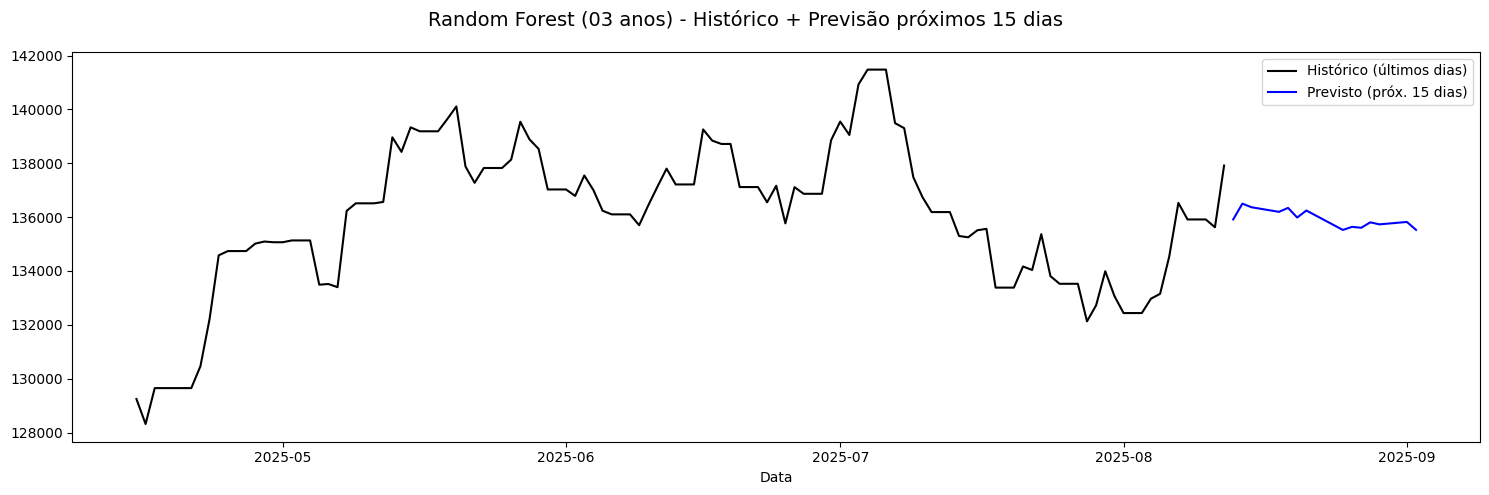

,DATA,PONTOS IBOVESPA PREVISTO
0,13/08/2025,135914.530
1,14/08/2025,136500.273
2,15/08/2025,136366.453
3,18/08/2025,136195.480
4,19/08/2025,136342.033
5,20/08/2025,135984.503
6,21/08/2025,136245.623
7,22/08/2025,136064.990
8,25/08/2025,135523.473
9,26/08/2025,135638.870


In [36]:
# Parâmetros (mesmos n_lags utilizados para o treino de 03 anos)
n_lags_used = 15
periodos_futuros = 15
usar_dias_uteis = True
janela_contexto = 120

# RRecuperação do modelo treinado
model_36m = resultados["36m"]["model"]

# Série completa da janela de 03 anos (treino + teste)
df_36_all = pd.concat([df_train_36[['ds','y']], df_test_36[['ds','y']]], ignore_index=True)
df_36_all['ds'] = pd.to_datetime(df_36_all['ds'], errors='coerce')
df_36_all = df_36_all.dropna(subset=['ds']).sort_values('ds').reset_index(drop=True)

# Última janela (n_lags) para iniciar a previsão
janela_y = df_36_all['y'].values[-n_lags_used:].astype(float)

# Previsão dos próximos 15 dias
preds = []
for _ in range(periodos_futuros):
    features = np.array([janela_y[-i] for i in range(1, n_lags_used + 1)], dtype=float).reshape(1, -1)
    yhat = model_36m.predict(features)[0]
    preds.append(yhat)

    janela_y = np.append(janela_y, yhat)[-n_lags_used:]

preds = np.array(preds)

# Geração de datas futuras a partir da última data com dados
last_ds = df_36_all['ds'].iloc[-1]
if usar_dias_uteis:
    futuras_ds = pd.bdate_range(start=last_ds + BDay(1), periods=periodos_futuros)
else:
    futuras_ds = pd.date_range(start=last_ds + pd.Timedelta(days=1), periods=periodos_futuros, freq='D')

df_future_15 = pd.DataFrame({"ds": futuras_ds, "y_previsto": preds})

# Plotagem dos Gráficos
hist_ctx = df_36_all.tail(janela_contexto).copy()

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle(
    f"Random Forest (03 anos) - Histórico + Previsão próximos {periodos_futuros} dias",
    fontsize=14
)
hist_ln, = ax.plot(pd.to_datetime(hist_ctx['ds']), hist_ctx['y'], "black", label="Histórico (últimos dias)")
fut_ln,  = ax.plot(df_future_15['ds'], df_future_15['y_previsto'], "blue",  label="Previsto (próx. 15 dias)")
ax.legend(handles=[hist_ln, fut_ln], fontsize=10)
ax.set_xlabel("Data", fontsize=10)
plt.tight_layout()
plt.show()

# Tabela formatada
df_future_15_fmt = df_future_15.rename(
    columns={"ds": "DATA", "y_previsto": "PONTOS IBOVESPA PREVISTO"}
).copy()
df_future_15_fmt["DATA"] = pd.to_datetime(df_future_15_fmt["DATA"]).dt.strftime("%d/%m/%Y")
df_future_15_fmt["PONTOS IBOVESPA PREVISTO"] = df_future_15_fmt["PONTOS IBOVESPA PREVISTO"].round(3)

display(df_future_15_fmt)

Abaixo, segue a assertividade calculada para esse modelo.

In [37]:
acc36 = resultados["36m"]["acc_original"]
print(f"Assertividade: {acc36:.2%}")


Assertividade: 99.02%


## 8.2 Comentários finais

Para o padrão de dados históricos do IBOVESPA, o SARIMA demonstrou ser uma saída com pouca confiabilidade. Os fatores que podem ter influenciado em sua performance é a complexidade dos padrões em que os pontos IBOVESPA aumentam ou decrescem, além de serem dados não-lineares.

Em relação a confiabilidade, o LSTM em uma janela de 05 anos foi o que apresentou o melhor resultado, e portanto seria o que selecionaria para a tomada de decisões financeiras futuras que envolvessem perfomance da bolsa de valores. Porém vale destacar que a médio prazo, tanto o Gradient Boosting quanto o Random Forest apresentaram bons resultados.
O sucesso desses casos se dá principalmente por serem modelos sensíveis à variações não lineares (como sazonalidades e tendências), aprendendo padrões complexos. Segue o consolidado da assertividade dos três modelos com previsões futuras:

In [39]:
acc5 = resultados_lstm["5 anos"]["acc_original"]
acc36gb = resultados_gb["36m"]["acc_original"]
acc36 = resultados["36m"]["acc_original"]

print(f"Assertividade LSTM (Janela de 05 anos): {acc5:.2%}\n")
print(f"Assertividade Gradient Boosting (Janela de 03 anos): {acc36gb:.2%}\n")
print(f"Assertividade Random Forest Regressor (Janela de 03 anos): {acc36:.2%}")

Assertividade LSTM (Janela de 05 anos): 99.39%

Assertividade Gradient Boosting (Janela de 03 anos): 99.10%

Assertividade Random Forest Regressor (Janela de 03 anos): 99.02%
